# Annotation

Consider a binary classification problem. We will fit a predictor and use it to assign a weight score to each node in each instance; this operation is referred to as "annotation". For illustration purposes we will display a few annotated graphs. We will see that building a predictor on the annotated instances can increase the predictive performance.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

/Users/costa/anaconda/envs/eden_env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


load data and convert it to graphs

In [2]:
pos = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_pos.gspan'
neg = 'http://www.bioinf.uni-freiburg.de/~costa/bursi_neg.gspan'

from eden.converter.graph.gspan import gspan_to_eden
iterable_pos = gspan_to_eden( pos )
iterable_neg = gspan_to_eden( neg )

#split train/test
train_test_split=0.7
from eden.util import random_bipartition_iter
iterable_pos_train, iterable_pos_test = random_bipartition_iter(iterable_pos, relative_size=train_test_split)
iterable_neg_train, iterable_neg_test = random_bipartition_iter(iterable_neg, relative_size=train_test_split)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
Starting new HTTP connection (1): www.bioinf.uni-freiburg.de


setup the vectorizer

In [3]:
from eden.graph import Vectorizer
vectorizer = Vectorizer(complexity=3)

In [4]:
%%time
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)
iterable_neg_train,iterable_neg_train_=tee(iterable_neg_train)
iterable_pos_test,iterable_pos_test_=tee(iterable_pos_test)
iterable_neg_test,iterable_neg_test_=tee(iterable_neg_test)

from eden.util import fit,estimate
estimator = fit(iterable_pos_train_, iterable_neg_train_, vectorizer)
estimate(iterable_pos_test_, iterable_neg_test_, estimator, vectorizer)

Test set
Instances: 1302 ; Features: 1048577 with an avg of 384 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.78      0.83      0.80       581
          1       0.86      0.81      0.83       721

avg / total       0.82      0.82      0.82      1302

APR: 0.906
ROC: 0.896
Cross-validated estimate
            accuracy: 0.796 +- 0.019
           precision: 0.827 +- 0.016
              recall: 0.800 +- 0.040
                  f1: 0.813 +- 0.021
   average_precision: 0.875 +- 0.019
             roc_auc: 0.858 +- 0.025
CPU times: user 11.1 s, sys: 1.91 s, total: 13 s
Wall time: 24.3 s


annotate instances and list all resulting graphs

display one graph as an example. Color the vertices using the annotated 'importance' attribute.

In [5]:
score_threshold = 1
min_size = 5

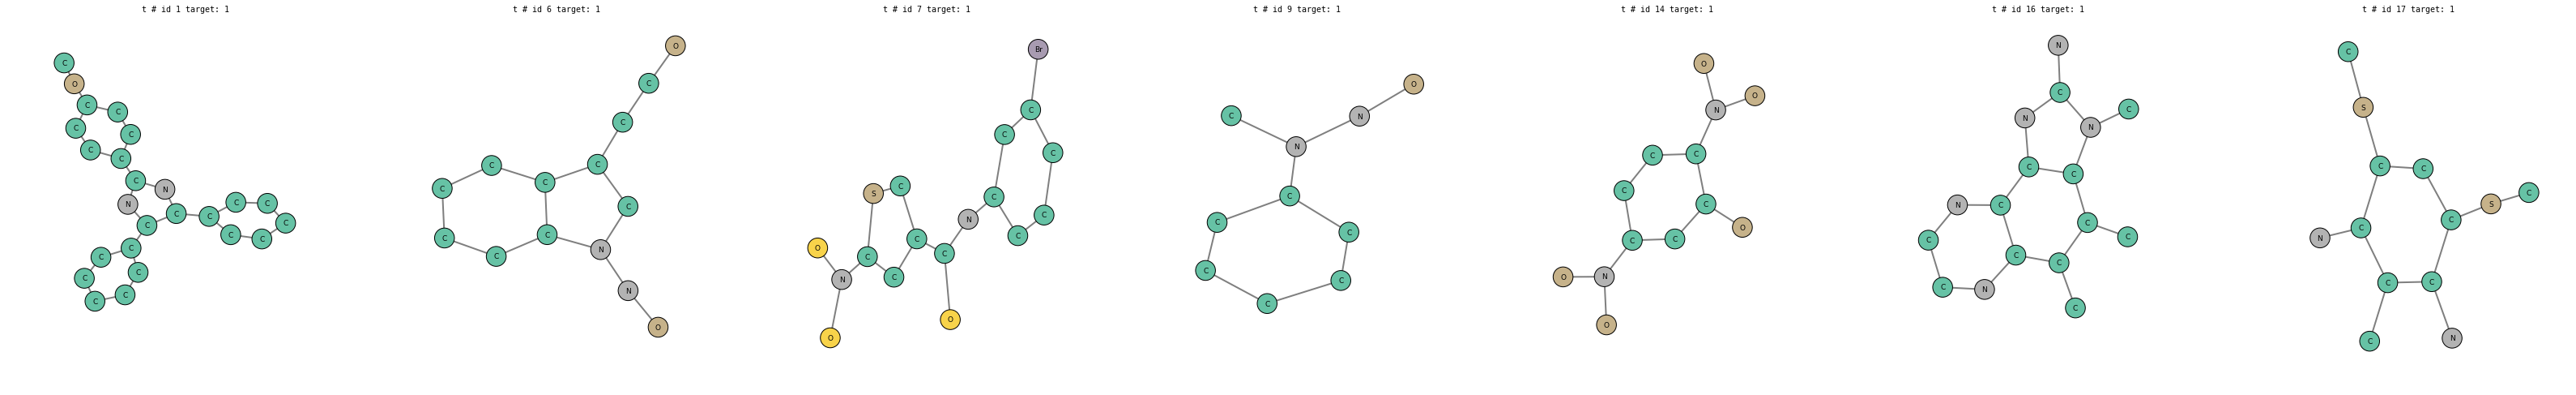

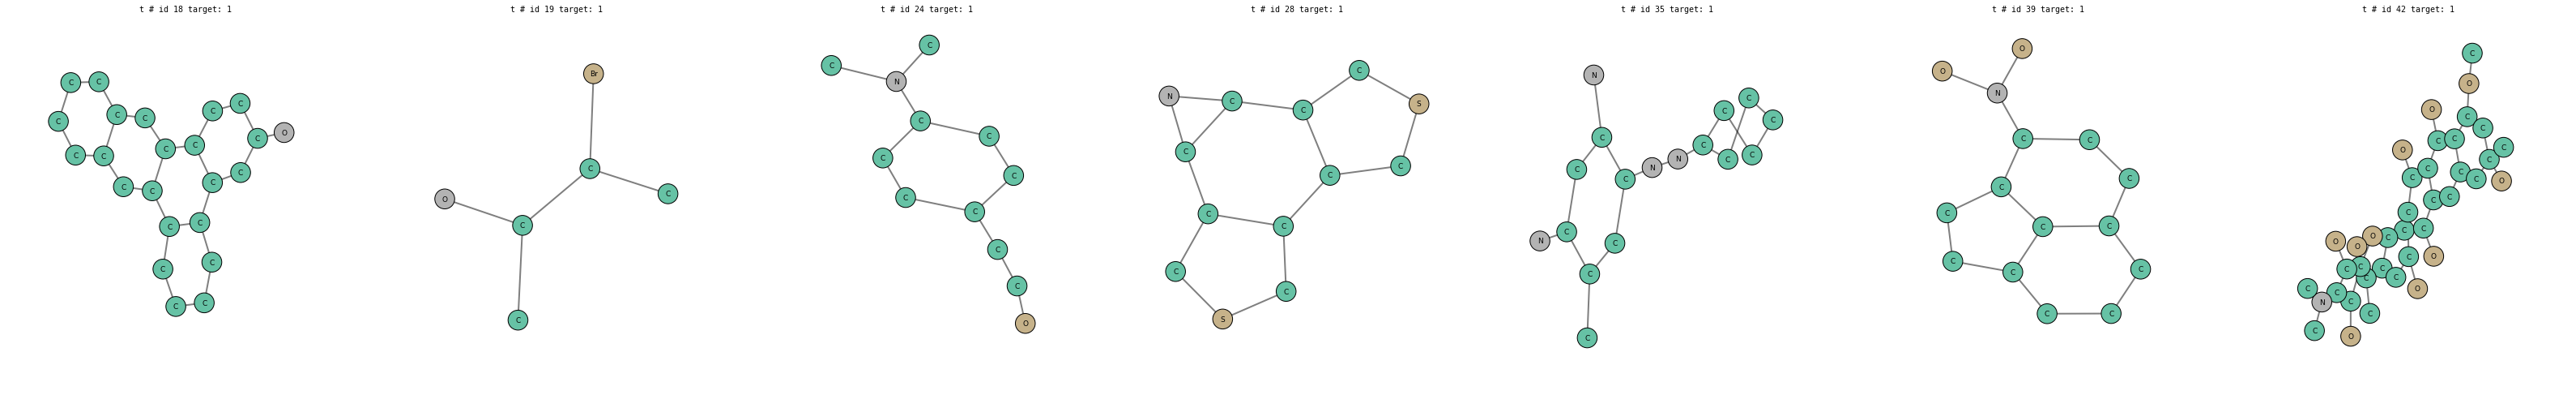

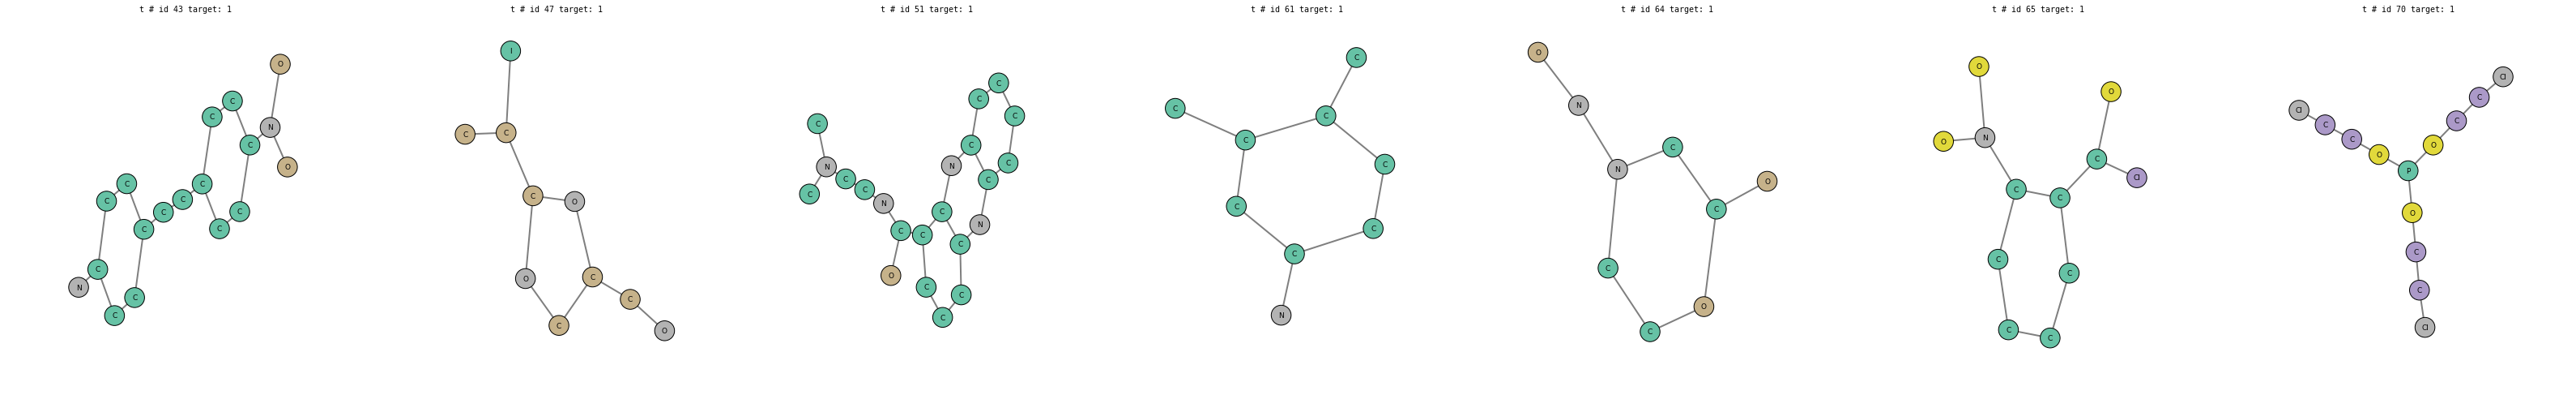

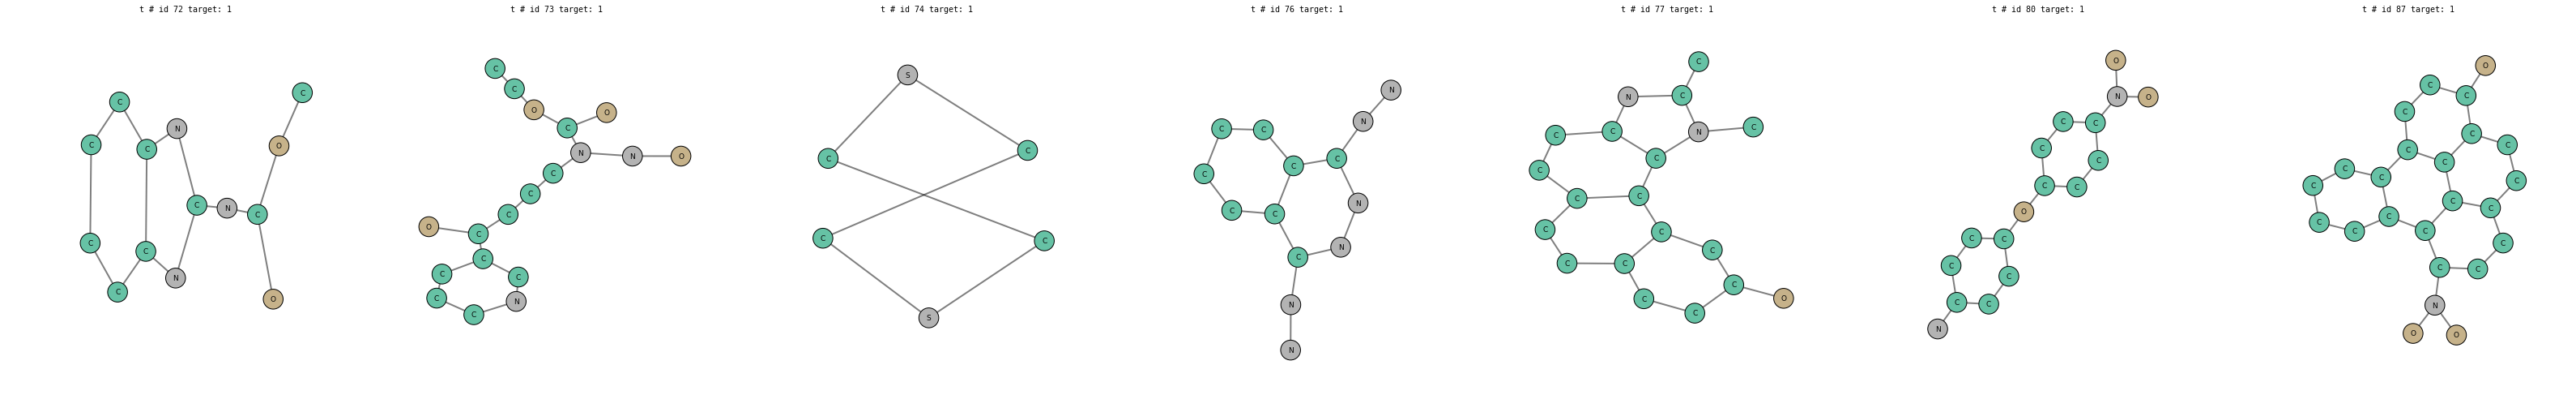

In [6]:
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

import itertools 
graphs = itertools.islice(iterable_pos_train_, 28)

from eden.util.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=7, size=8, vertex_color='_label_', prog='neato', node_border=1, colormap='Set2', vertex_alpha=1)

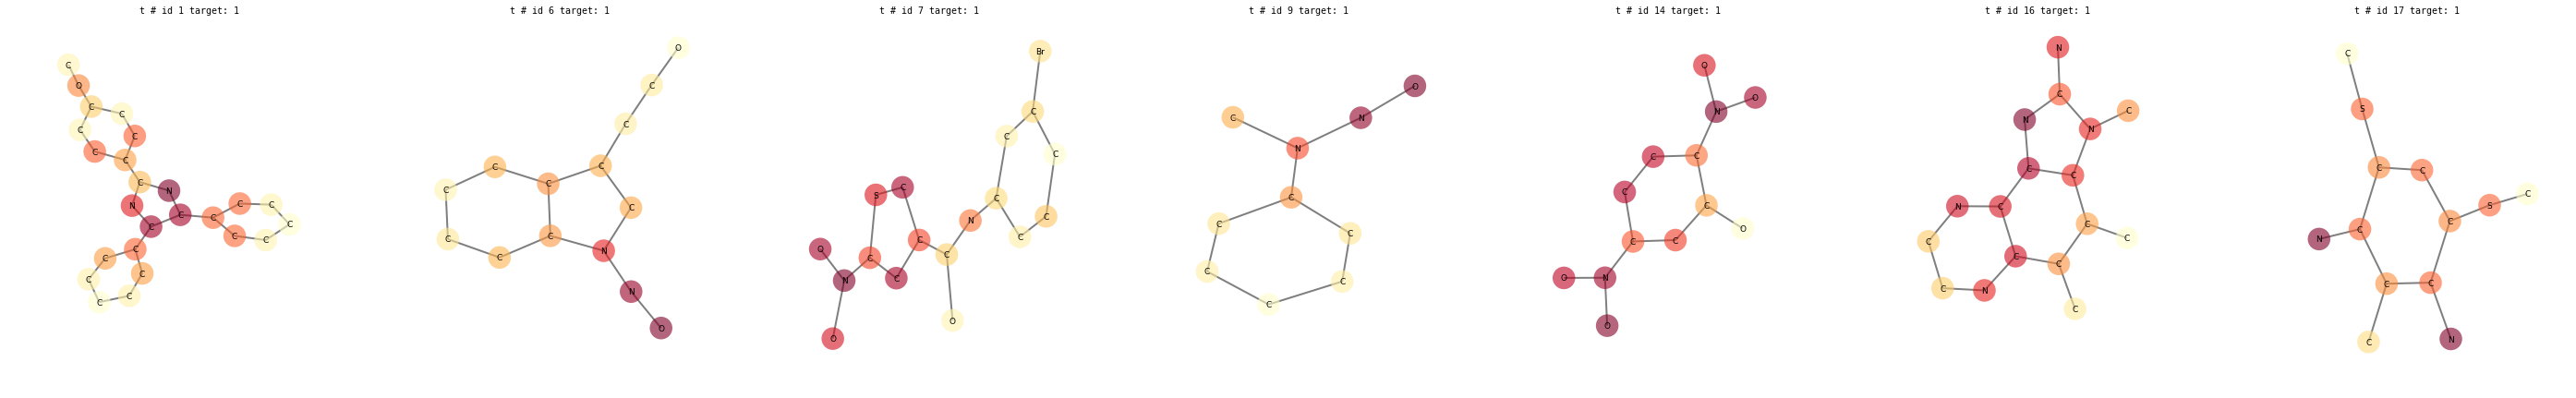

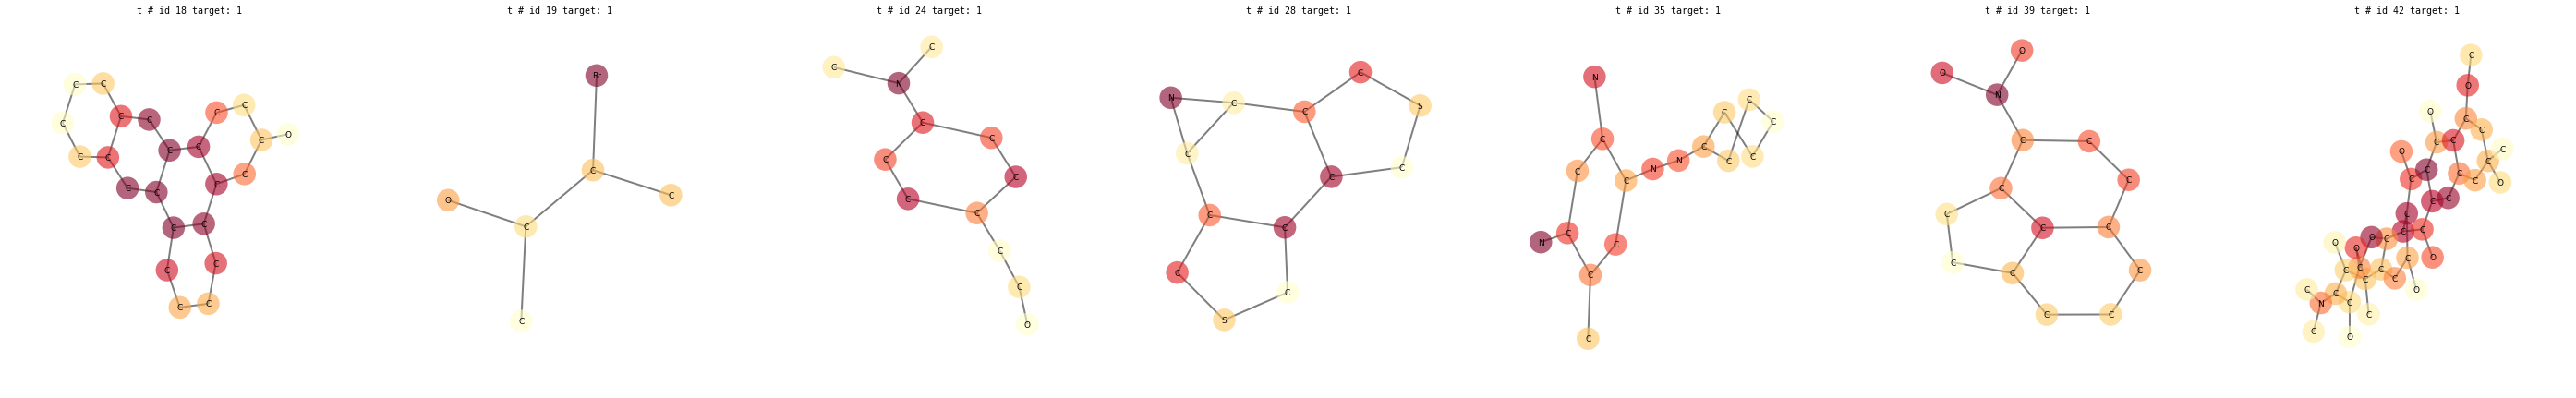

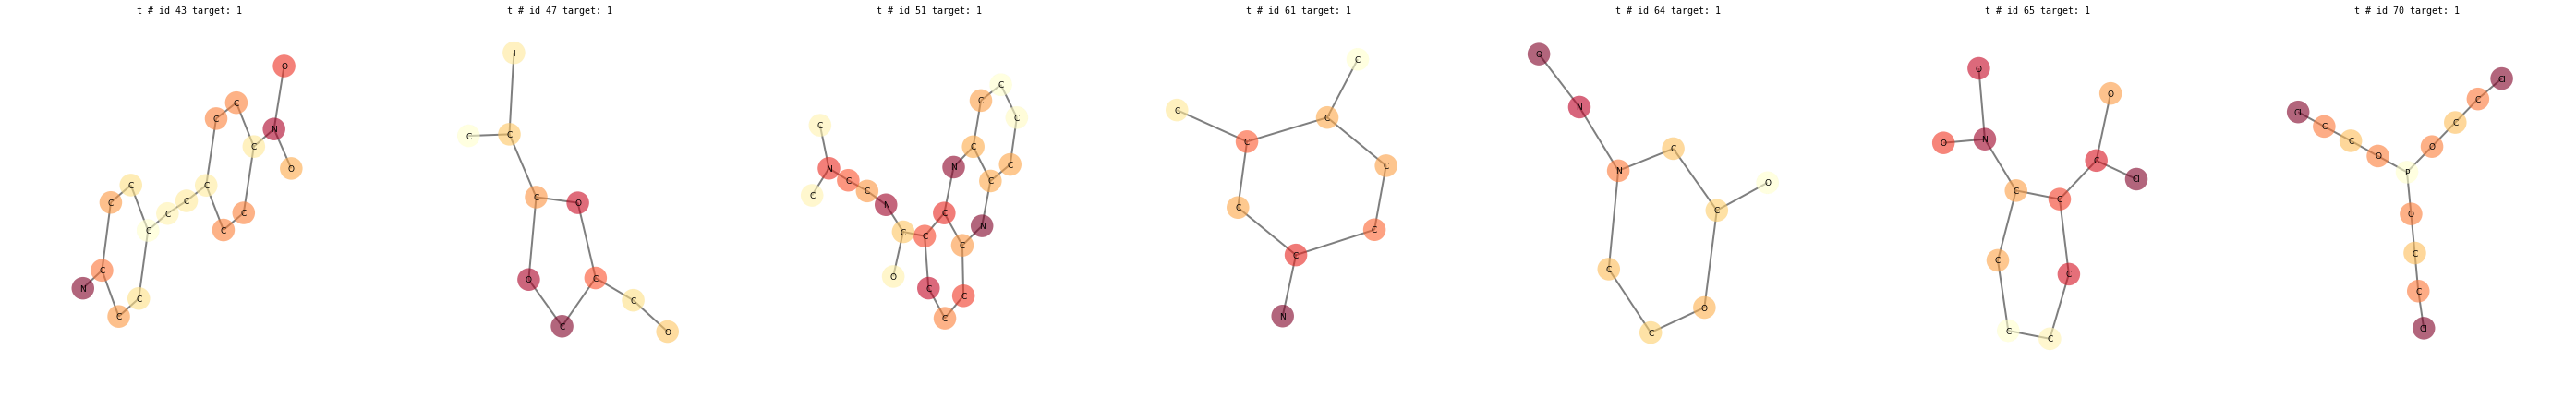

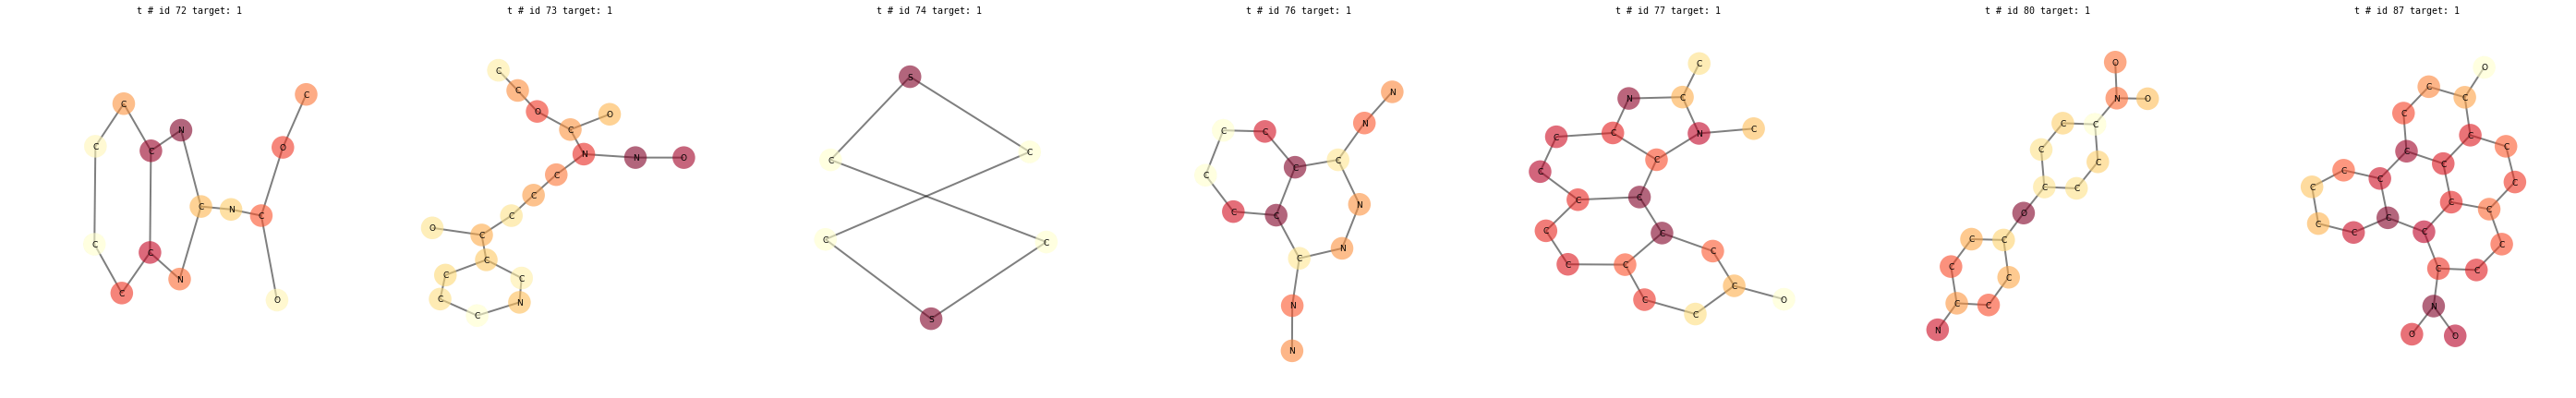

In [7]:
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.annotate( iterable_pos_train_, estimator=estimator )

import itertools 
graphs = itertools.islice(graphs, 28)

from eden.util.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=7, size=7, vertex_color='importance', prog='neato')

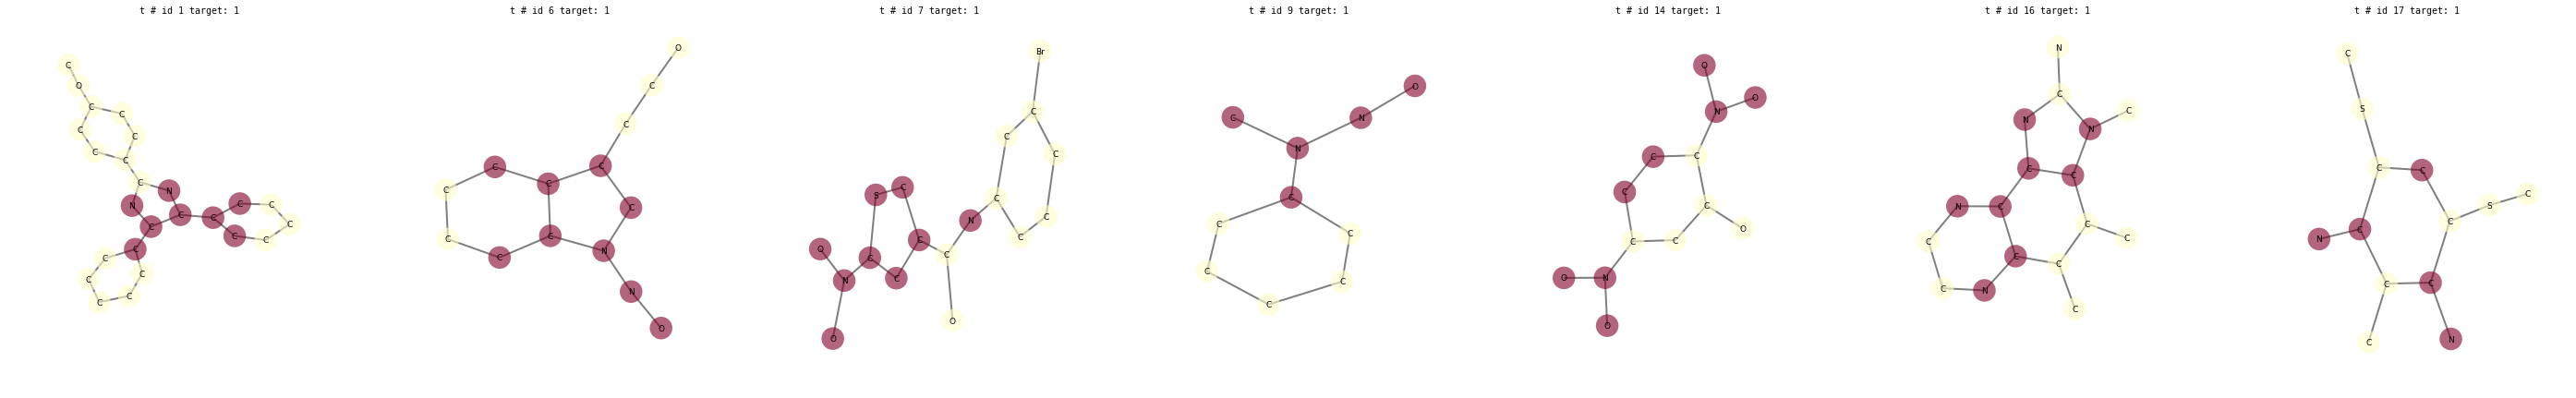

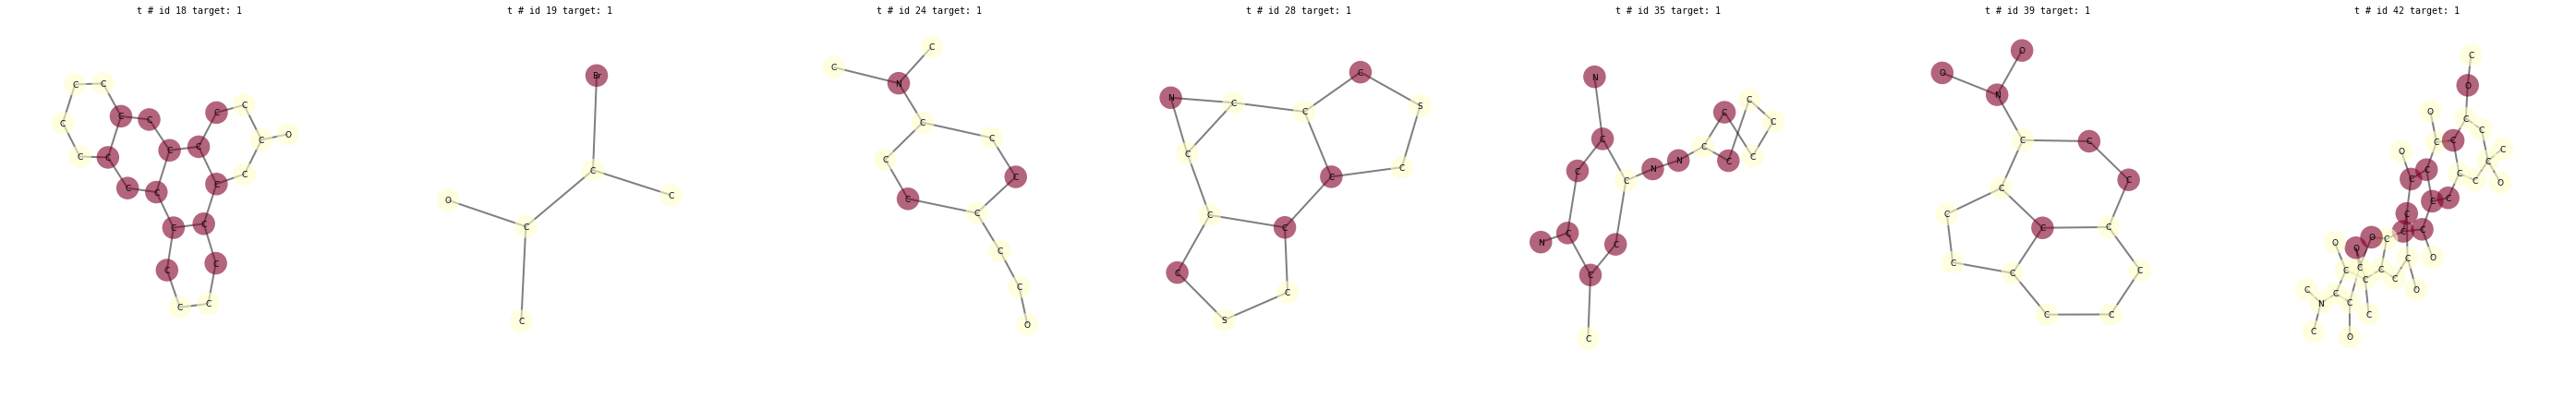

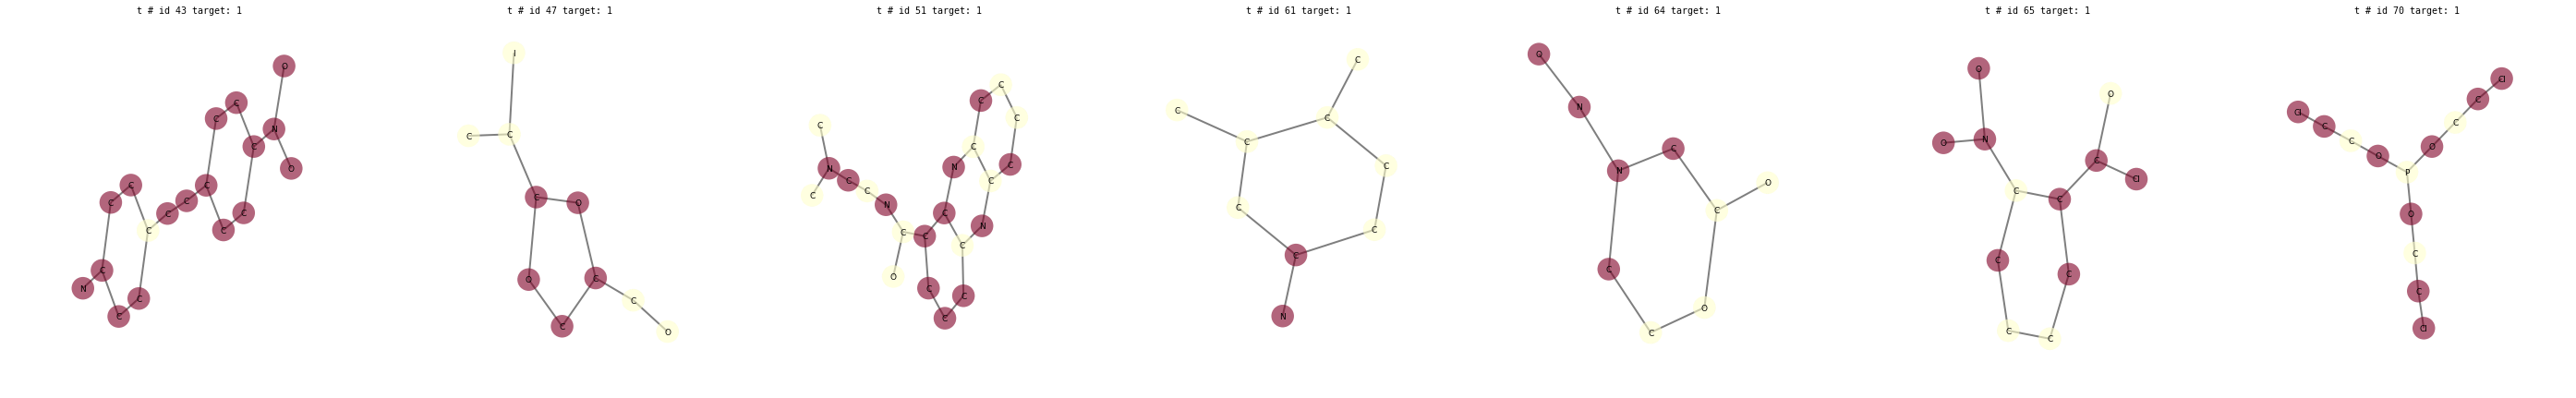

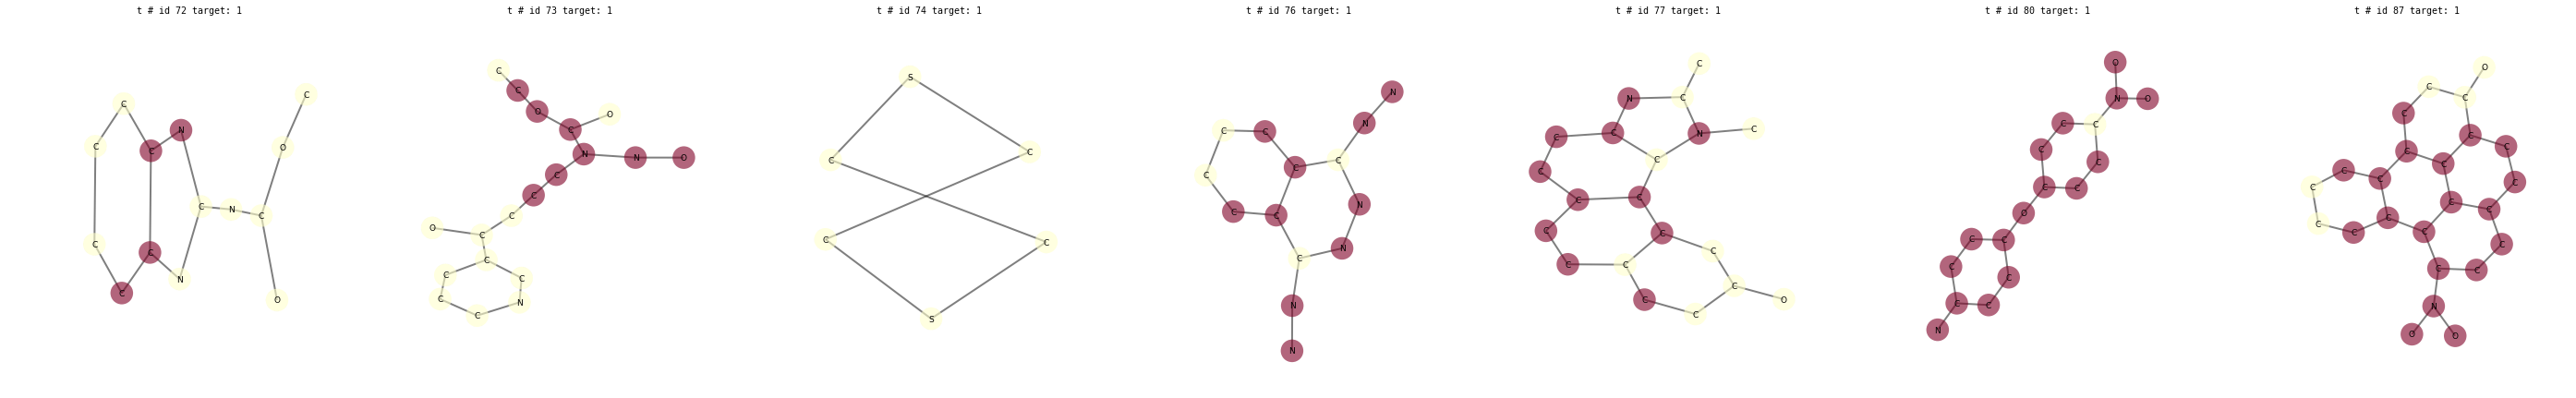

In [8]:
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.annotate( iterable_pos_train_, estimator=estimator )

import itertools 
graphs = itertools.islice(graphs, 28)

from eden.modifier.graph.vertex_attributes import colorize_binary
graphs = colorize_binary(graph_list = graphs, output_attribute = 'color_value', input_attribute='importance', level=score_threshold)

from eden.util.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=7, size=7, vertex_color='color_value', prog='neato')

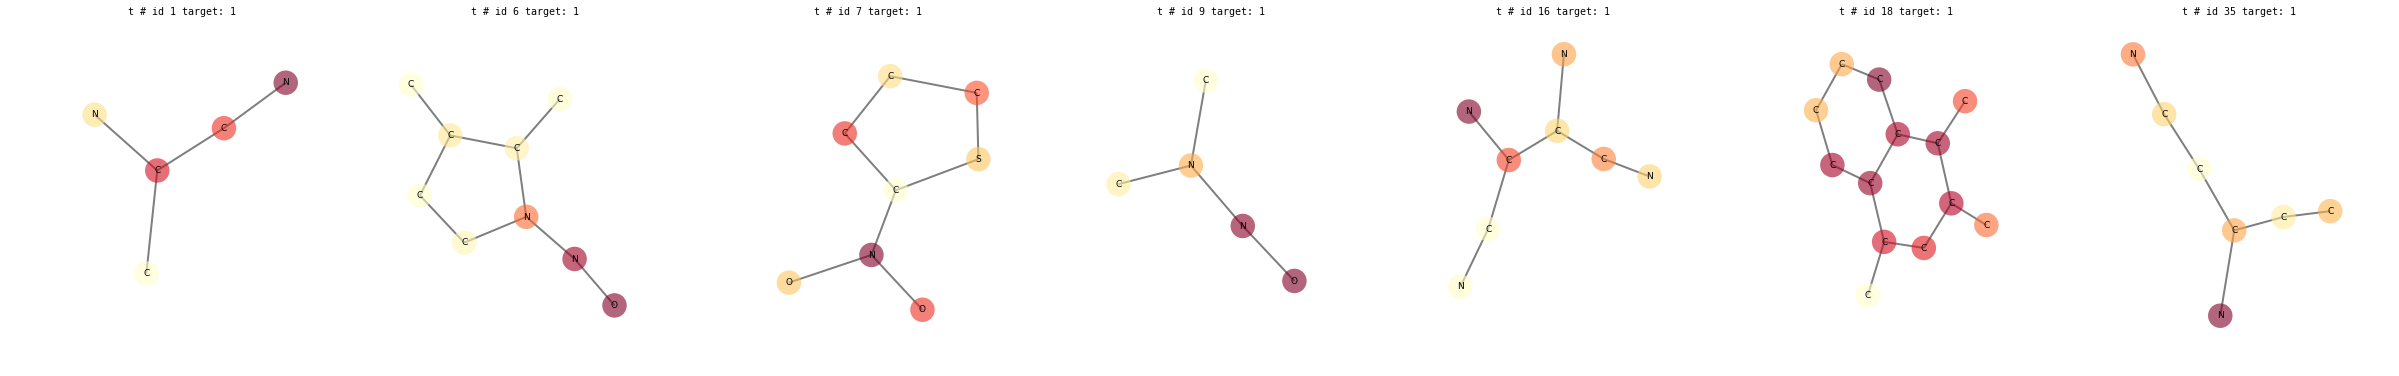

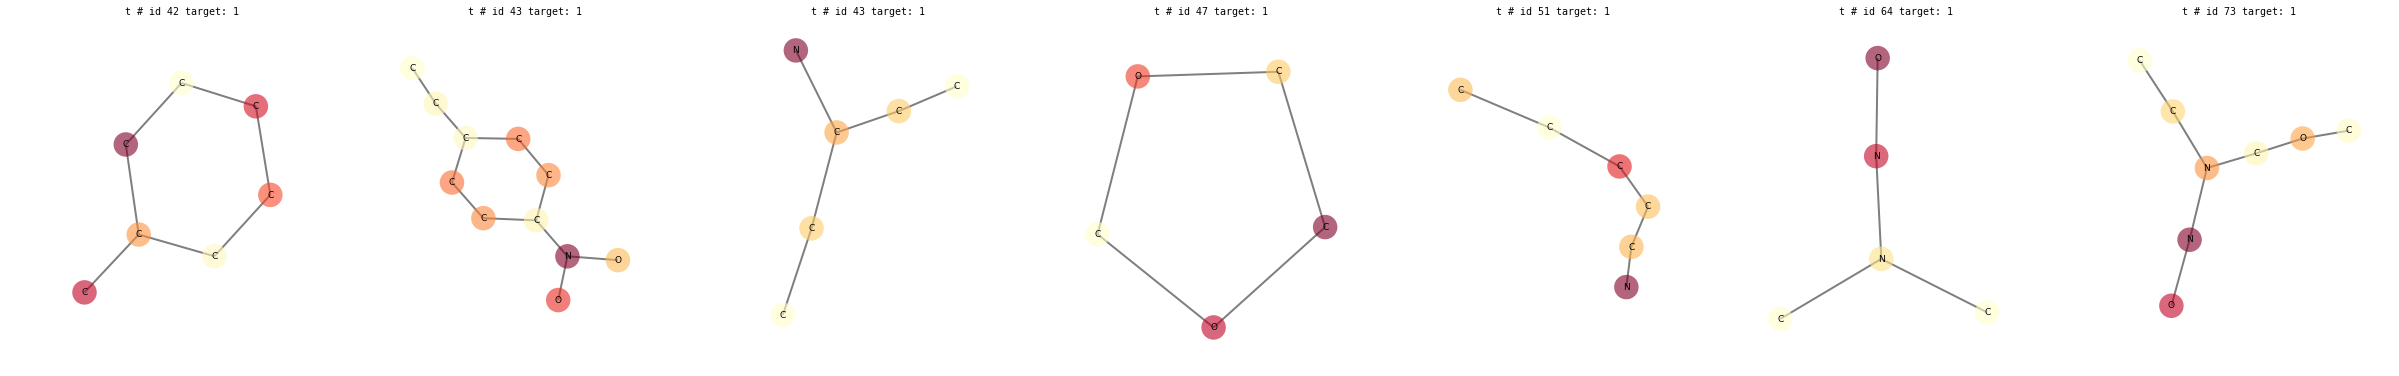

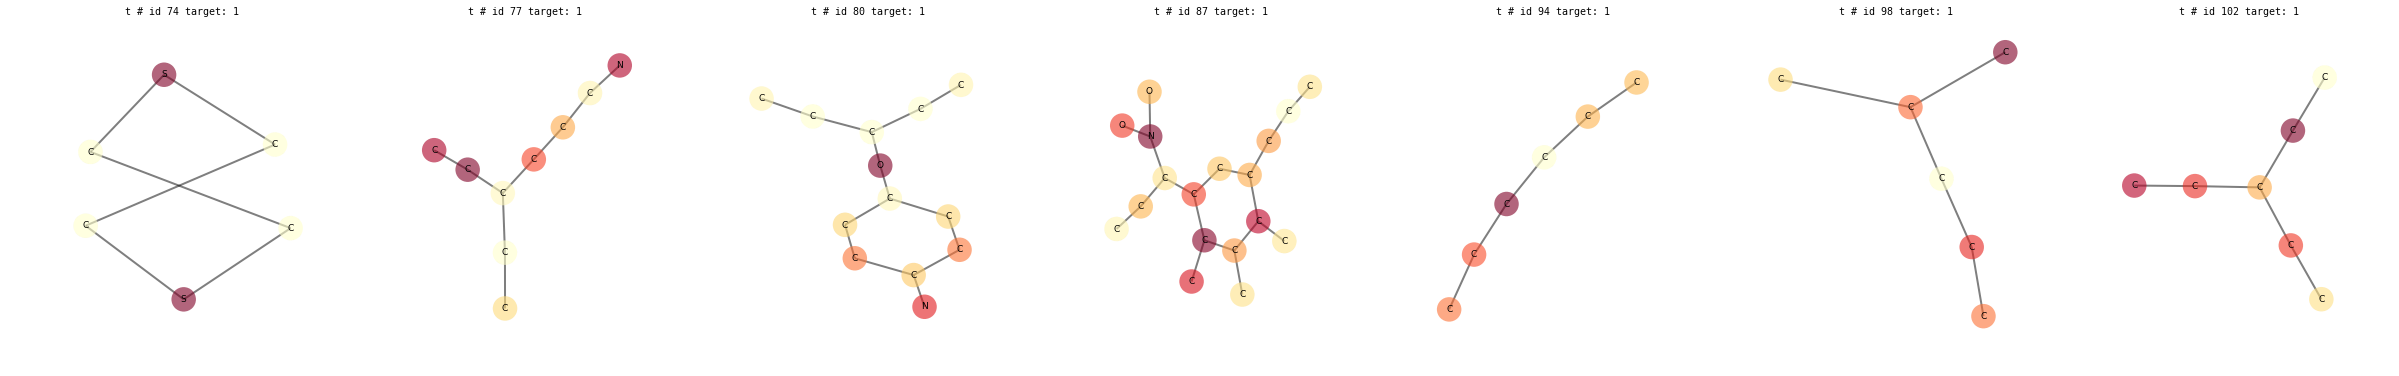

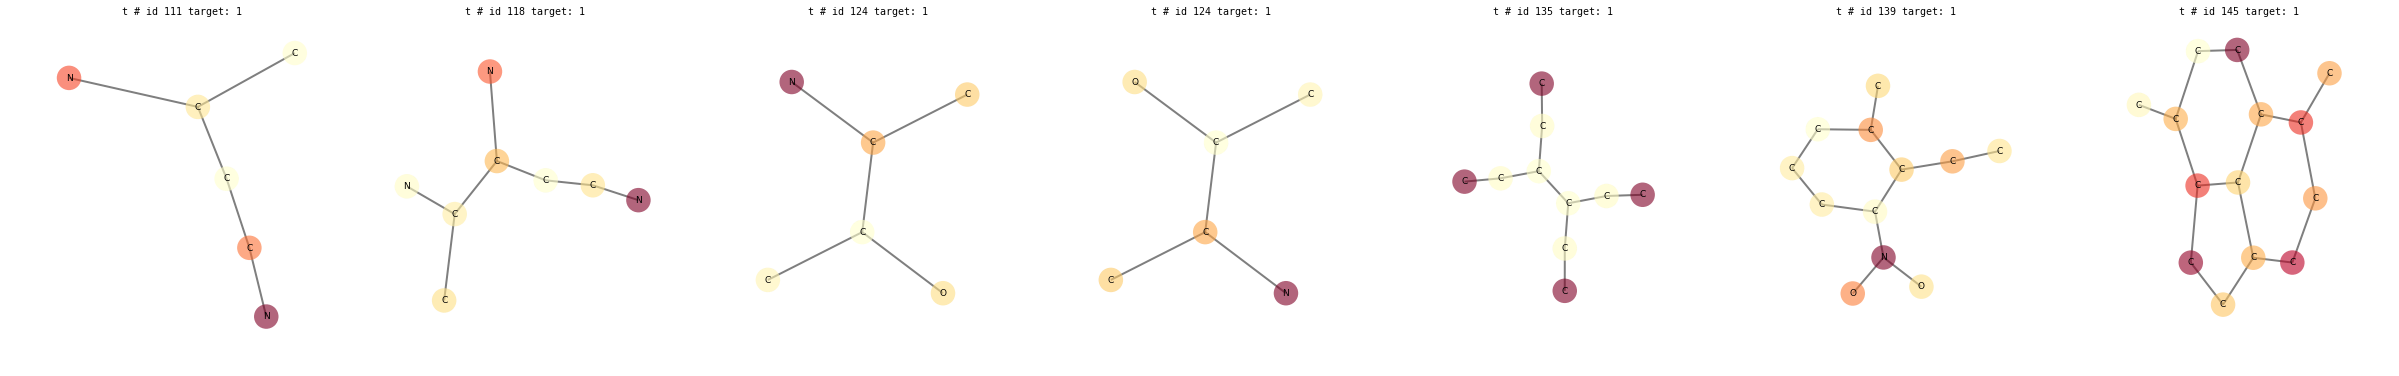

In [9]:
%matplotlib inline
from itertools import tee
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)

graphs = vectorizer.components(iterable_pos_train_, estimator=estimator, score_threshold=score_threshold, min_size=min_size)

import itertools 
graphs = itertools.islice( graphs, 28)

from eden.util.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=7, size=6, vertex_color='importance', prog='neato')

In [10]:
%%time
# cluster the components
iterable_pos_train,iterable_pos_train_=tee(iterable_pos_train)
graphs = vectorizer.components(iterable_pos_train_, estimator=estimator, score_threshold=score_threshold, min_size=min_size)
graphs = list(graphs)
data_matrix = vectorizer.transform(graphs)
print data_matrix.shape

(901, 1048577)
CPU times: user 30 s, sys: 2.3 s, total: 32.3 s
Wall time: 32.3 s


In [11]:
%%time
ALGO='DBSCAN'
if ALGO=='DBSCAN':
    distance_std_factor = 2
    import numpy as np
    from sklearn.metrics.pairwise import pairwise_distances
    distance_matrix = pairwise_distances(data_matrix)
    eps = np.mean(distance_matrix) - distance_std_factor * np.std(distance_matrix)
    print 'eps:%.4f'%eps
    from sklearn.cluster import DBSCAN
    clust = DBSCAN(eps=eps, min_samples=10)
    cluster_ids = clust.fit_predict(data_matrix)
elif ALGO=='KMEANS':
    from sklearn.cluster import MiniBatchKMeans
    clust = MiniBatchKMeans(n_clusters=80)
    cluster_ids = clust.fit_predict(data_matrix)


print len(cluster_ids)
print 'num clusters: %d' % max(cluster_ids)
from eden.util import report_base_statistics
print report_base_statistics(cluster_ids).replace('\t','\n')

eps:1.0295
901
num clusters: 11
class: 0 count:17 (0.02)
class: 1 count:367 (0.41)
class: 2 count:45 (0.05)
class: 3 count:18 (0.02)
class: 4 count:13 (0.01)
class: 5 count:19 (0.02)
class: 6 count:11 (0.01)
class: 7 count:37 (0.04)
class: 8 count:27 (0.03)
class: 9 count:21 (0.02)
class: 10 count:21 (0.02)
class: 11 count:11 (0.01)
class: -1 count:294 (0.33)

CPU times: user 240 ms, sys: 16.7 ms, total: 257 ms
Wall time: 262 ms


cluster id: 0  num: 17


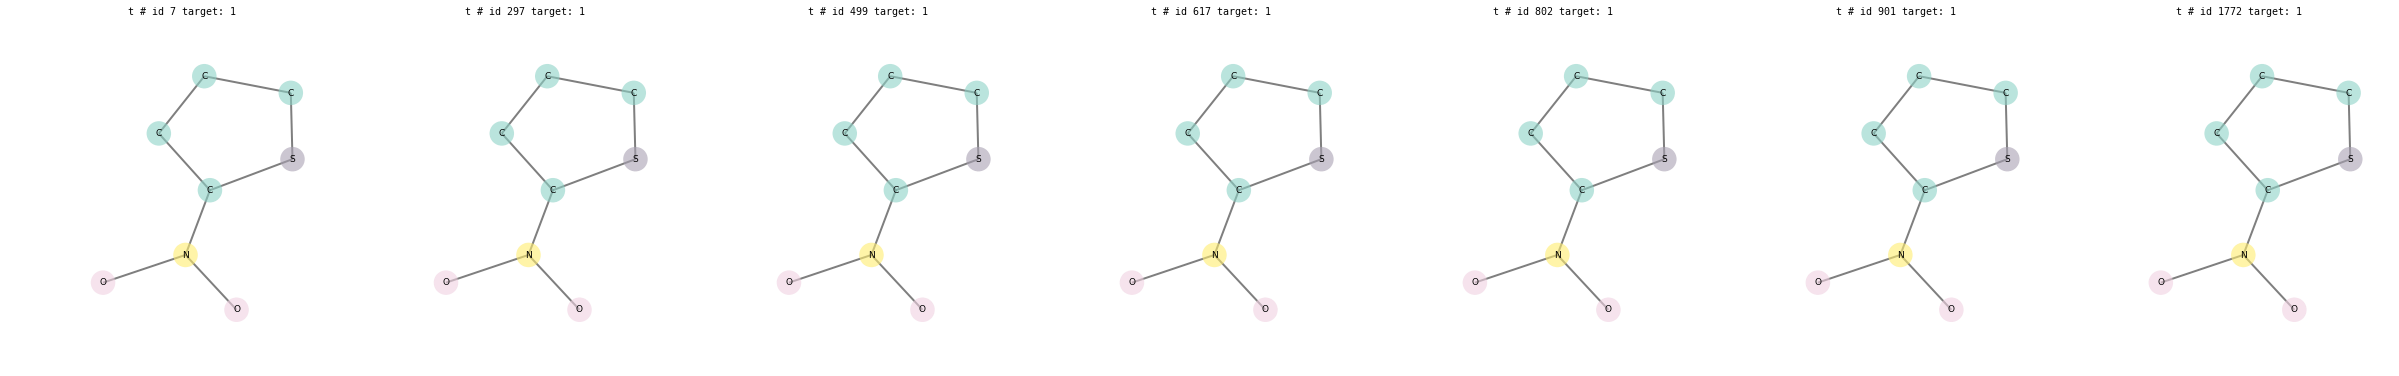

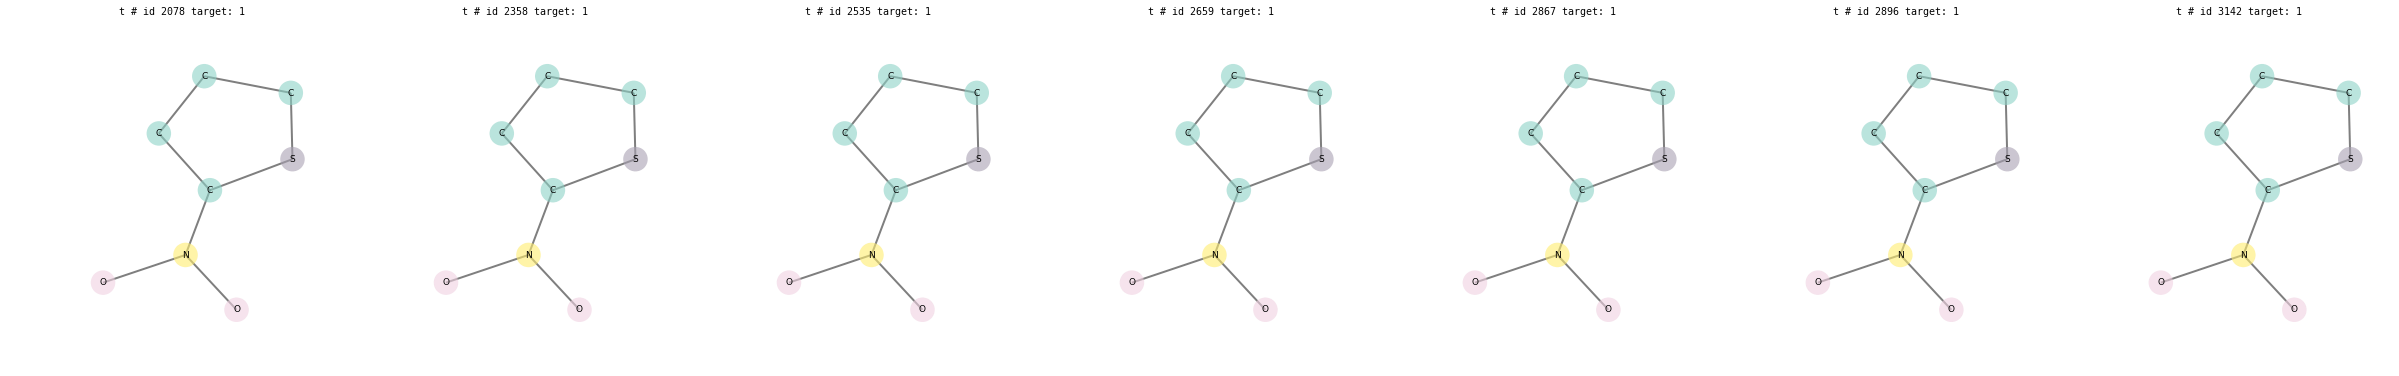

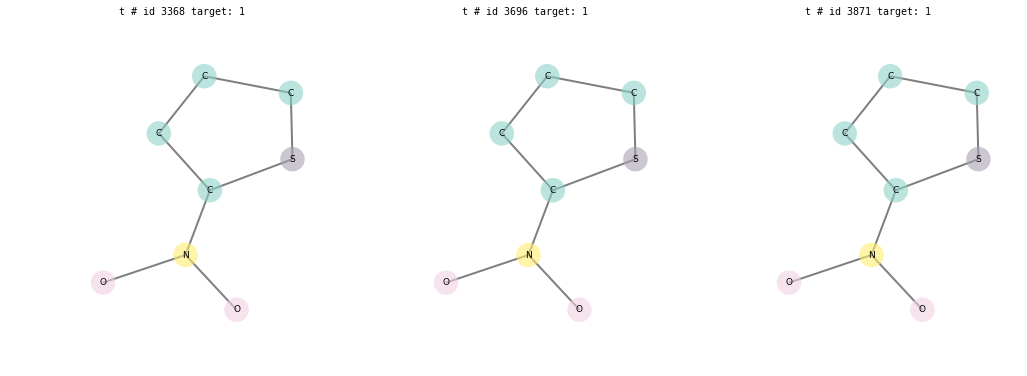

cluster id: 1  num: 367


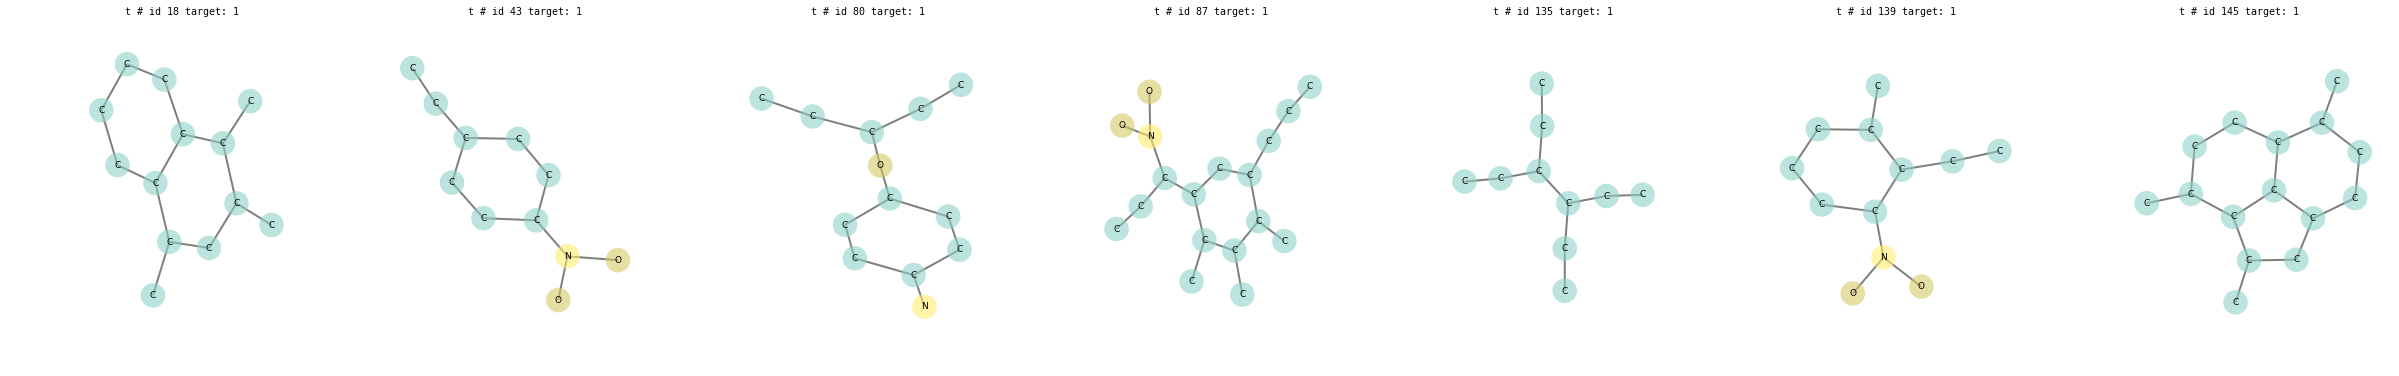

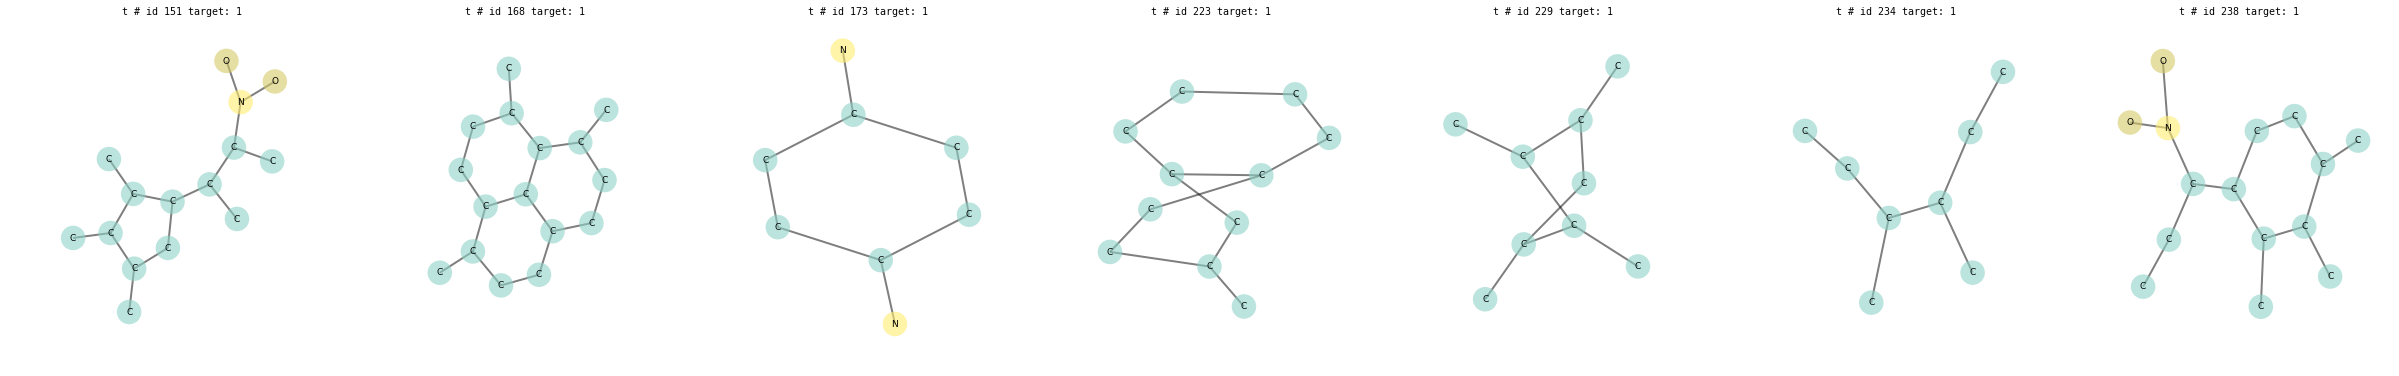

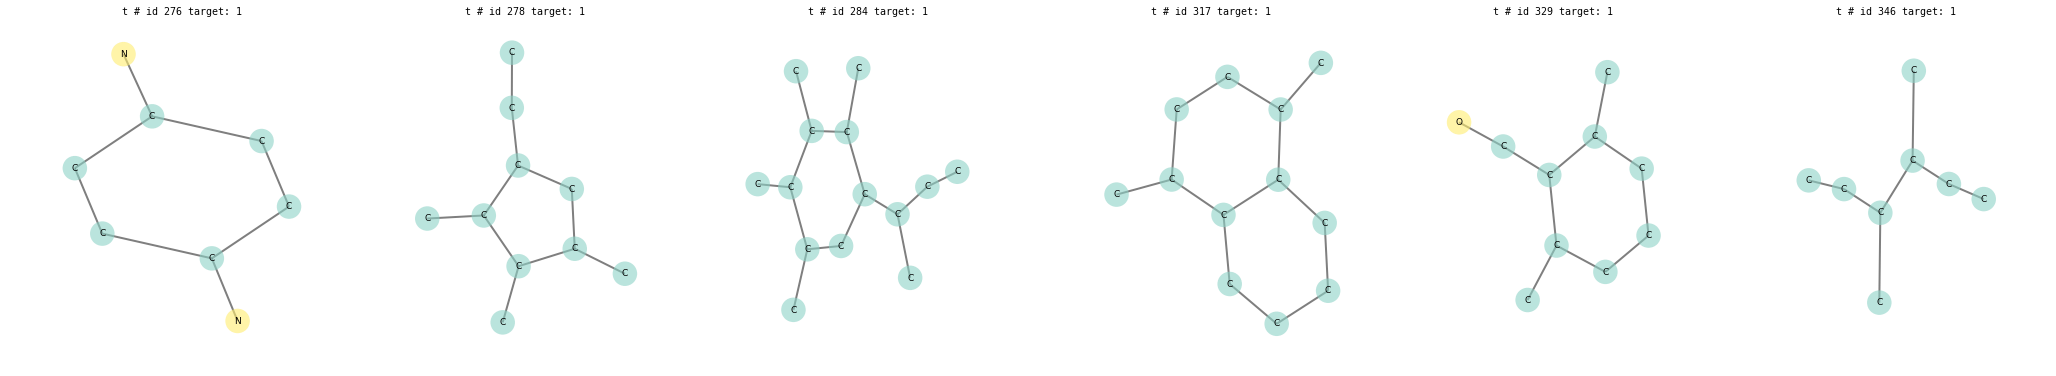

cluster id: 2  num: 45


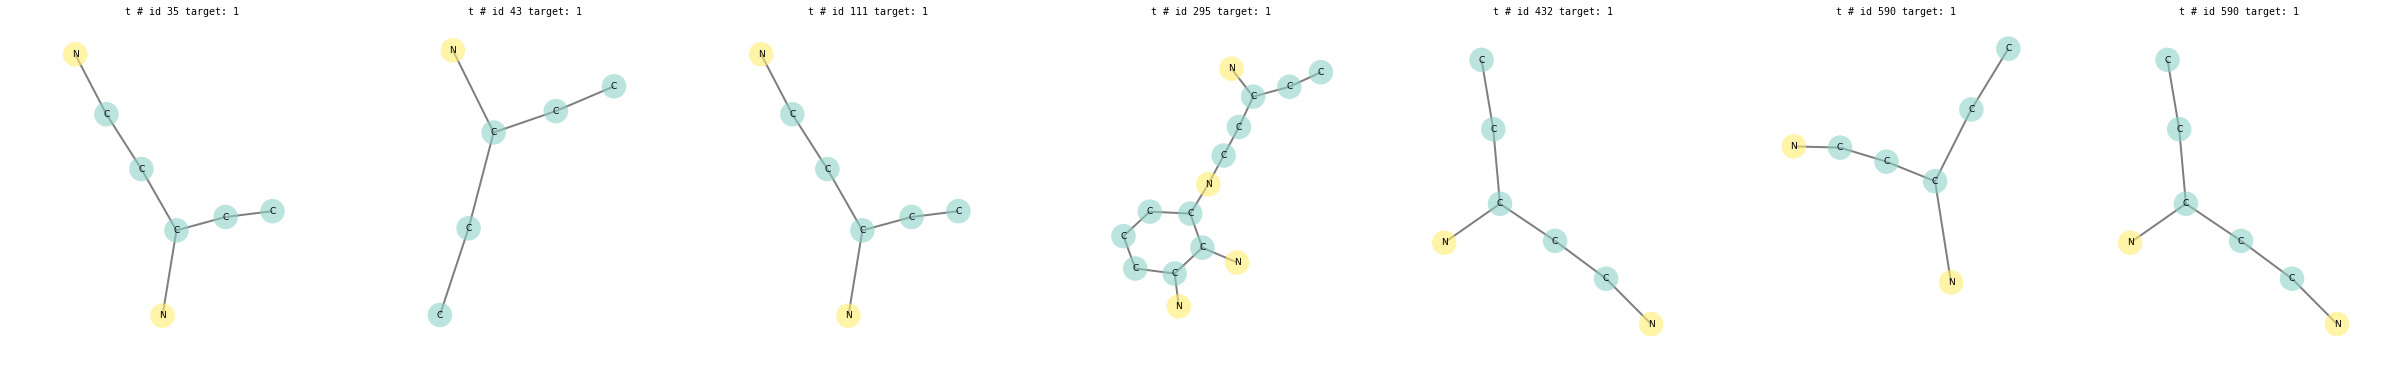

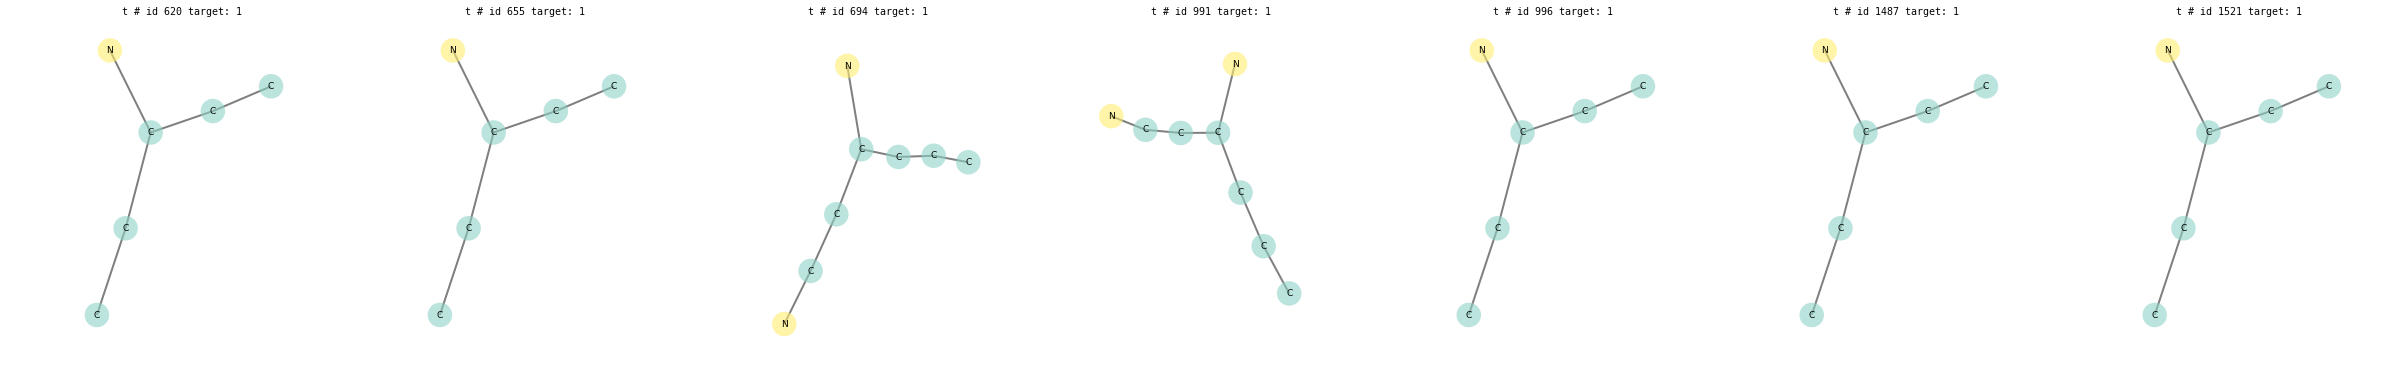

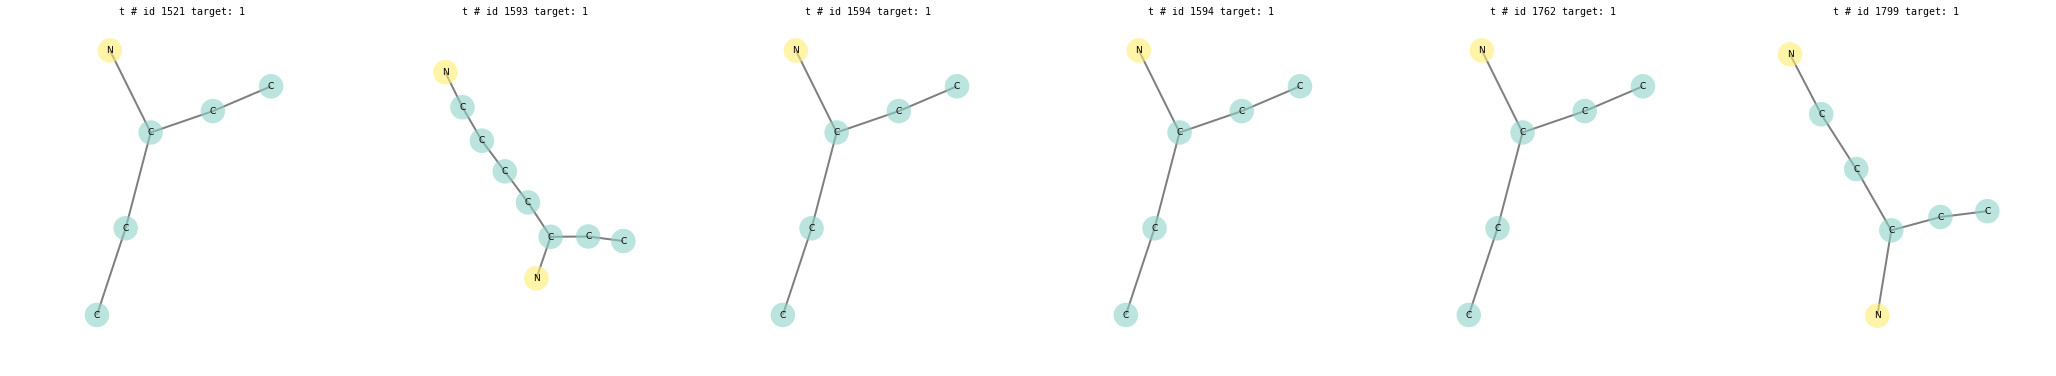

cluster id: 3  num: 18


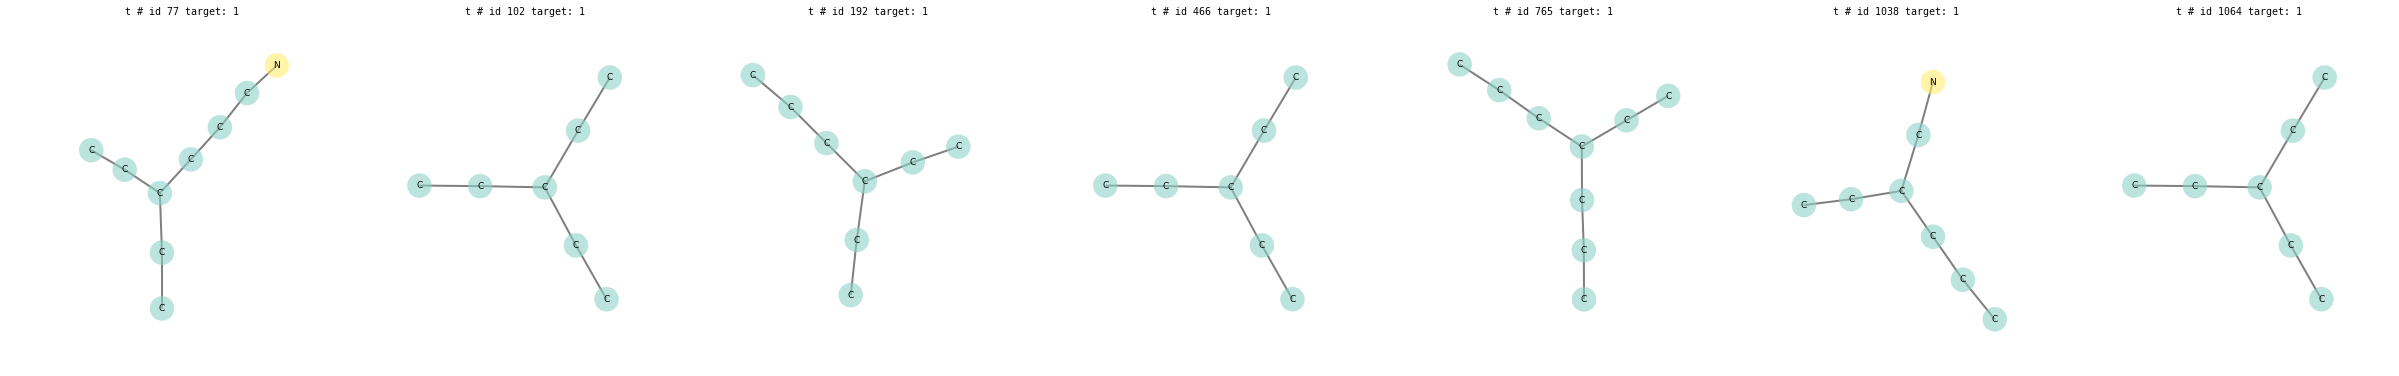

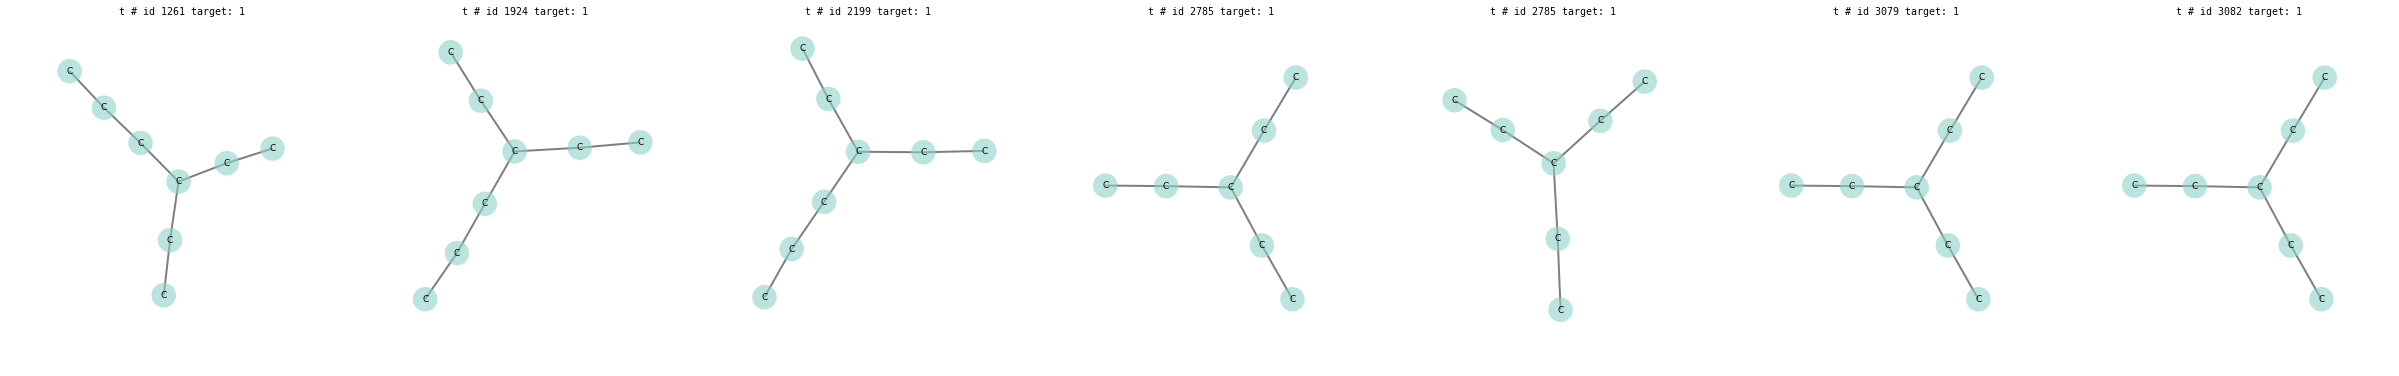

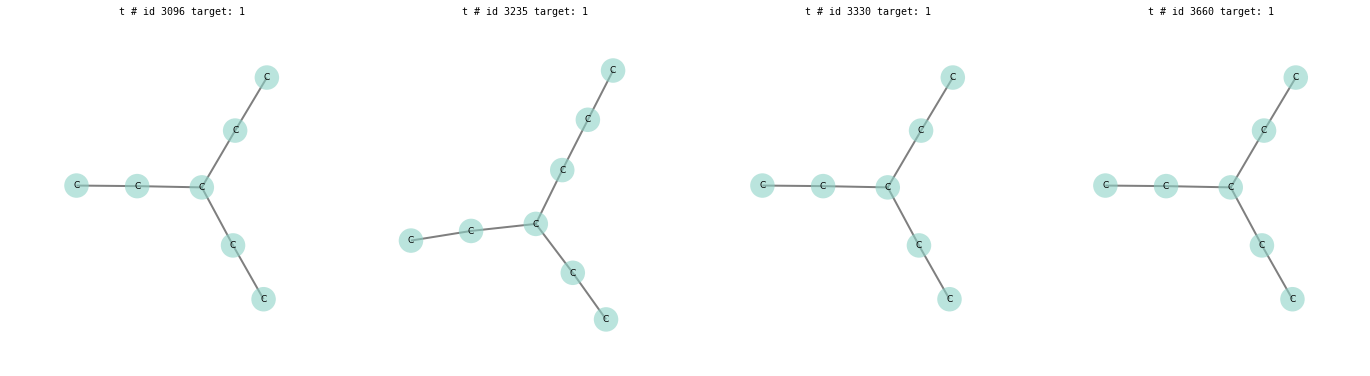

cluster id: 4  num: 13


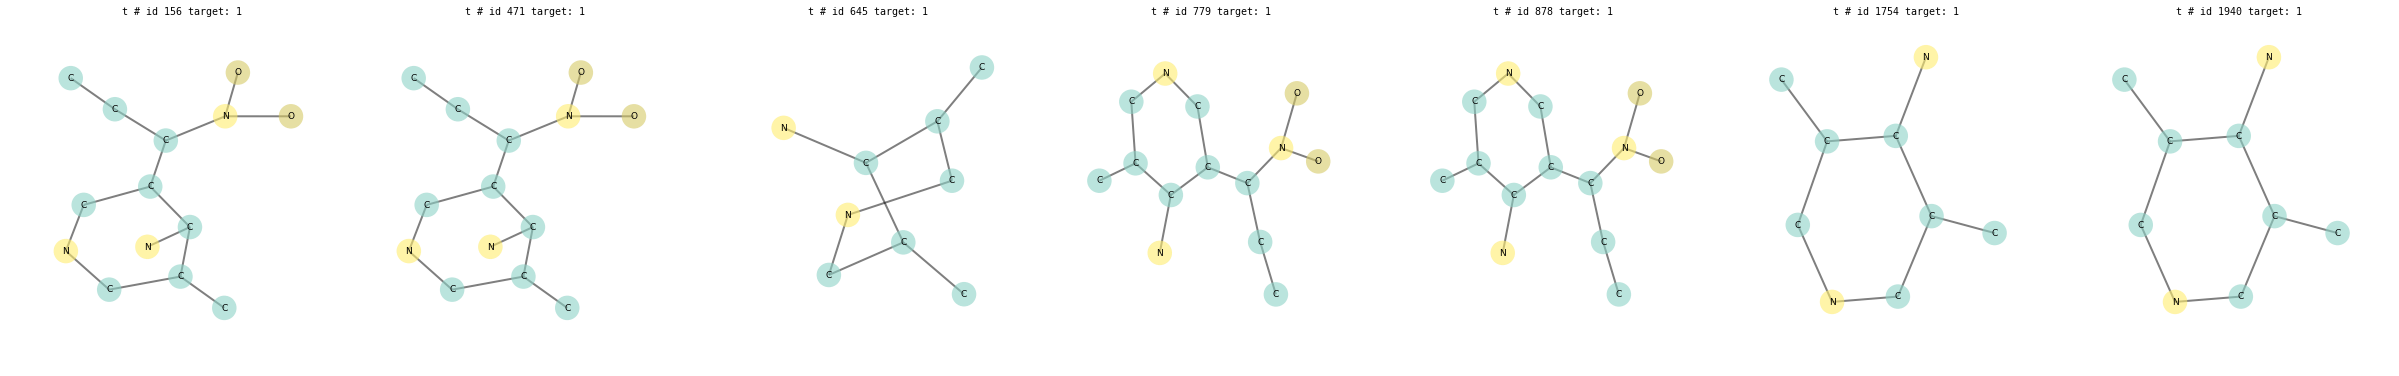

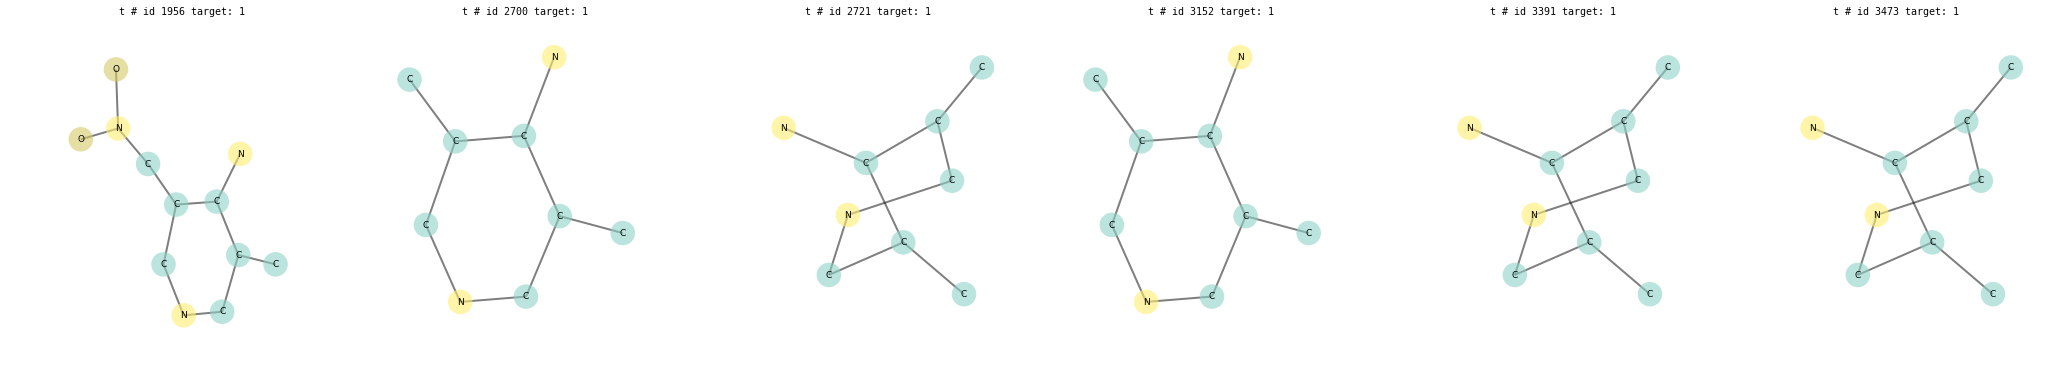

cluster id: 5  num: 19


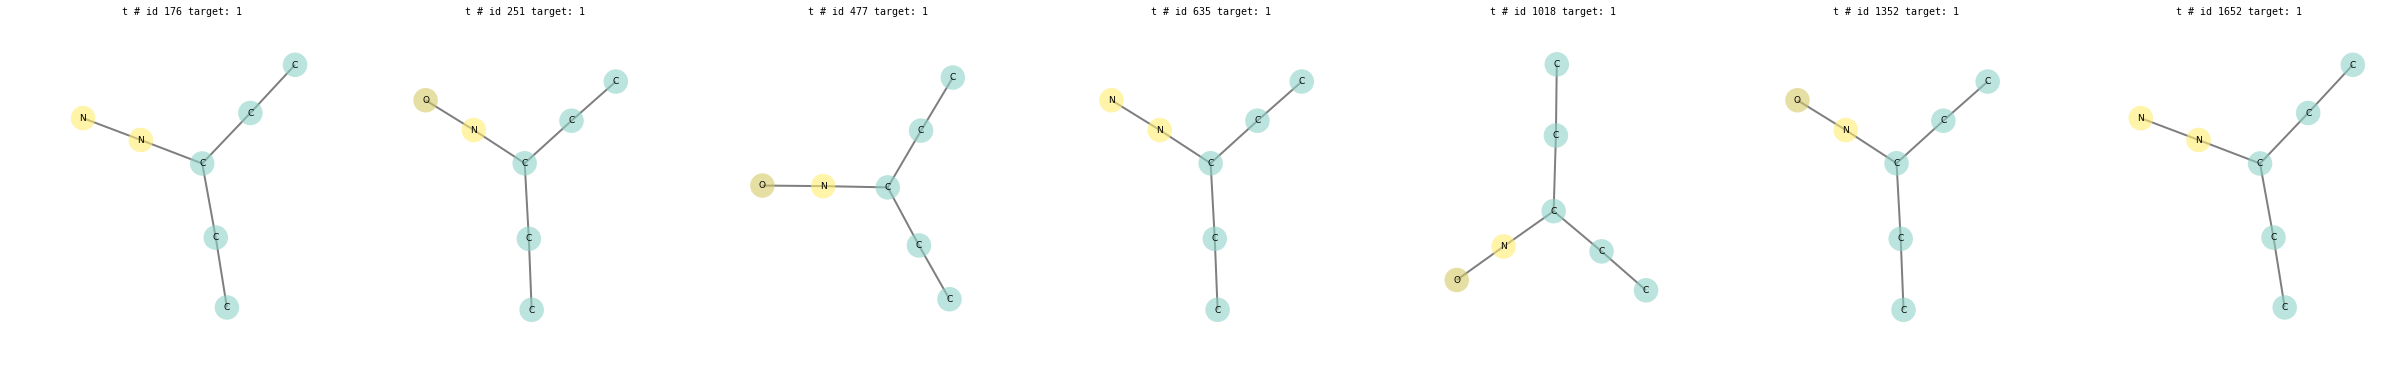

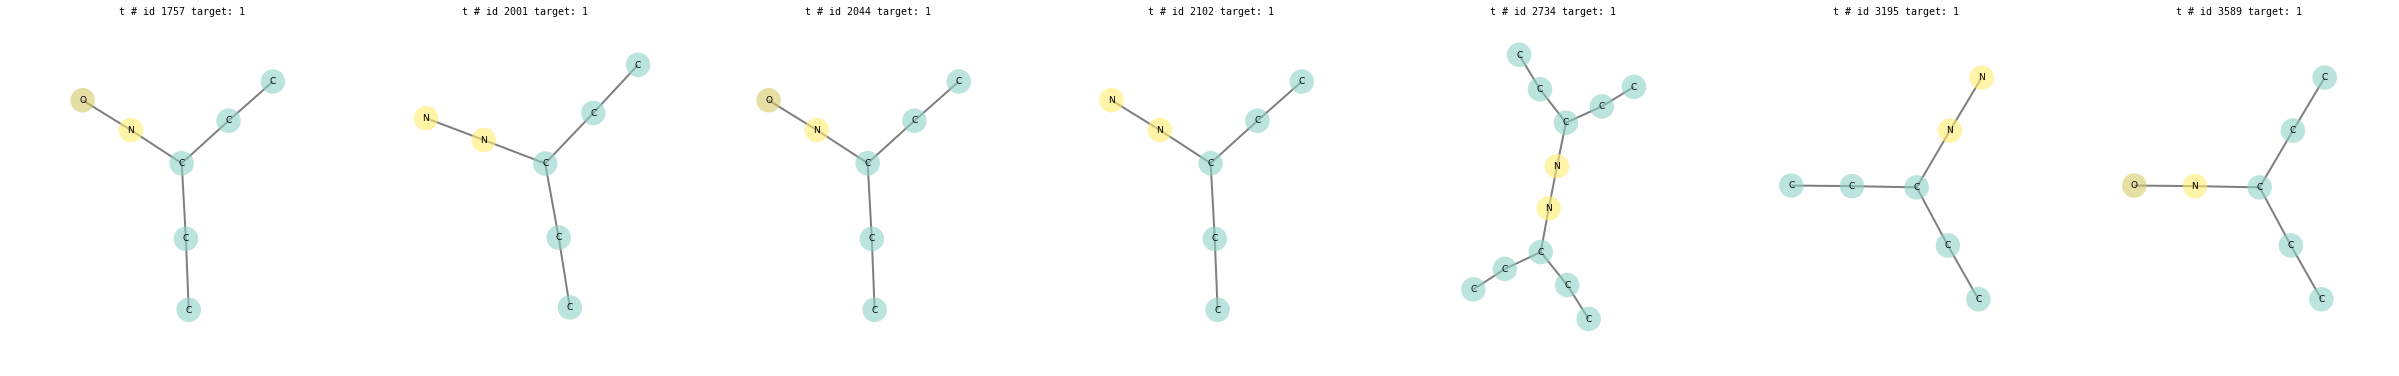

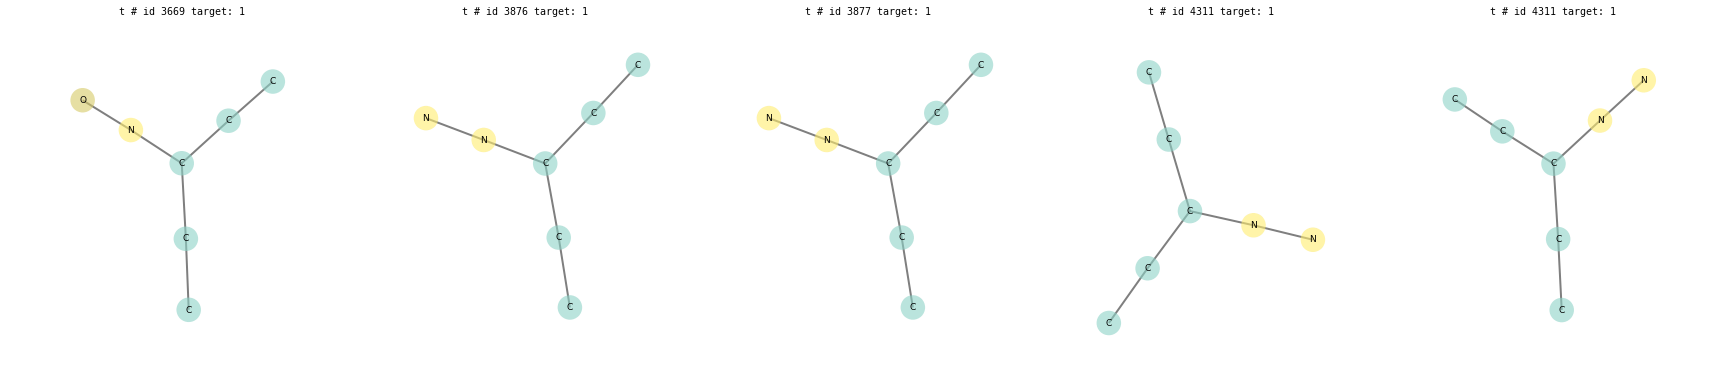

cluster id: 6  num: 11


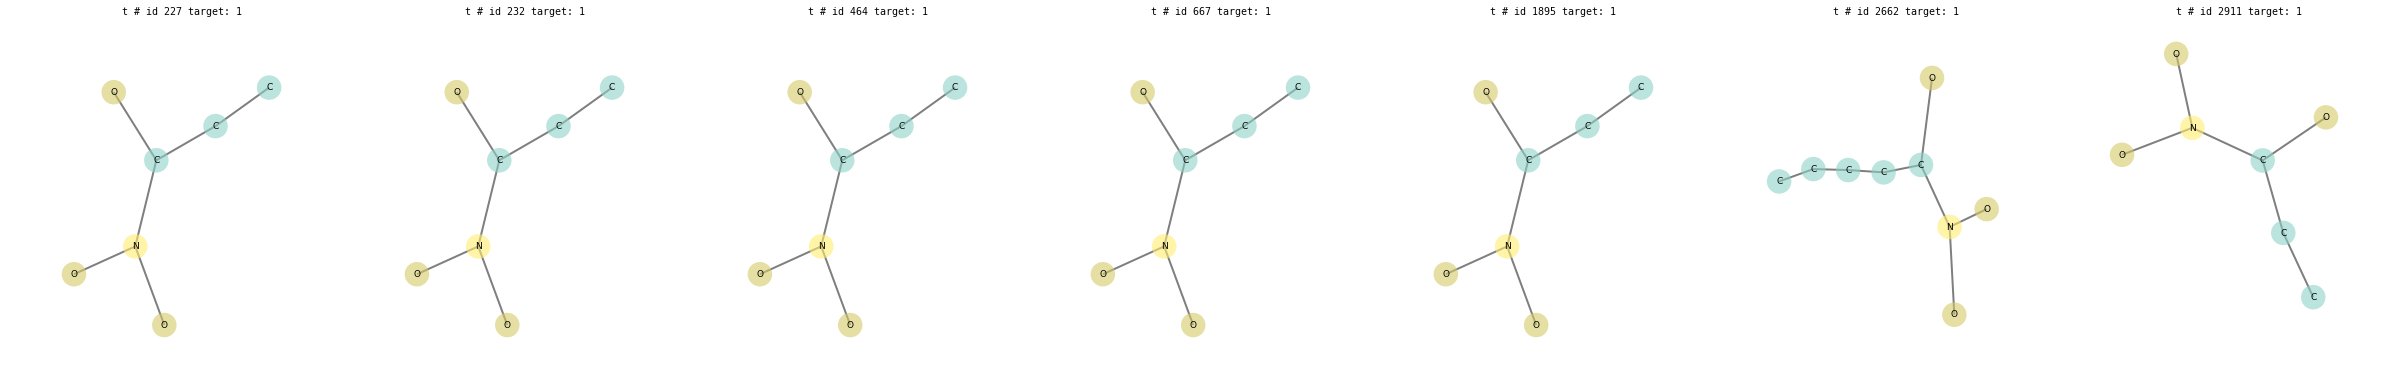

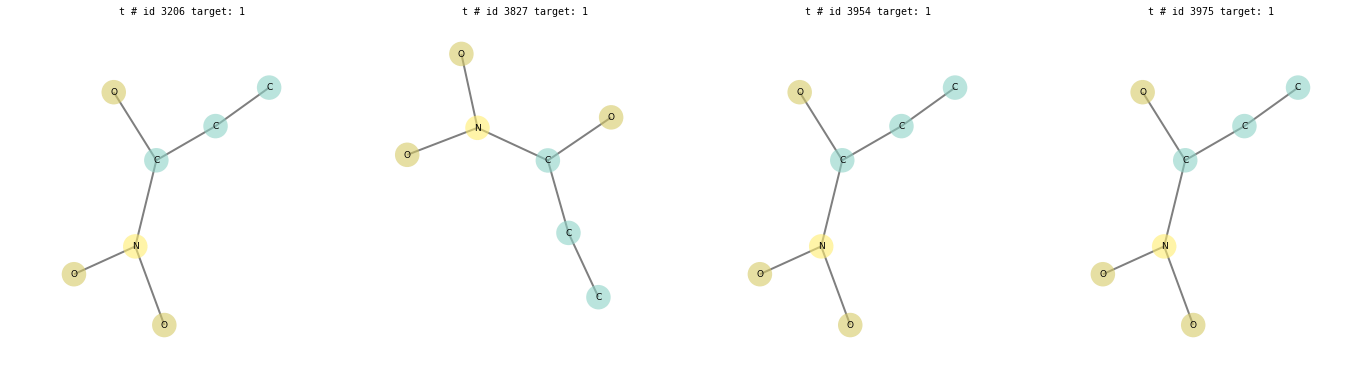

cluster id: 7  num: 37


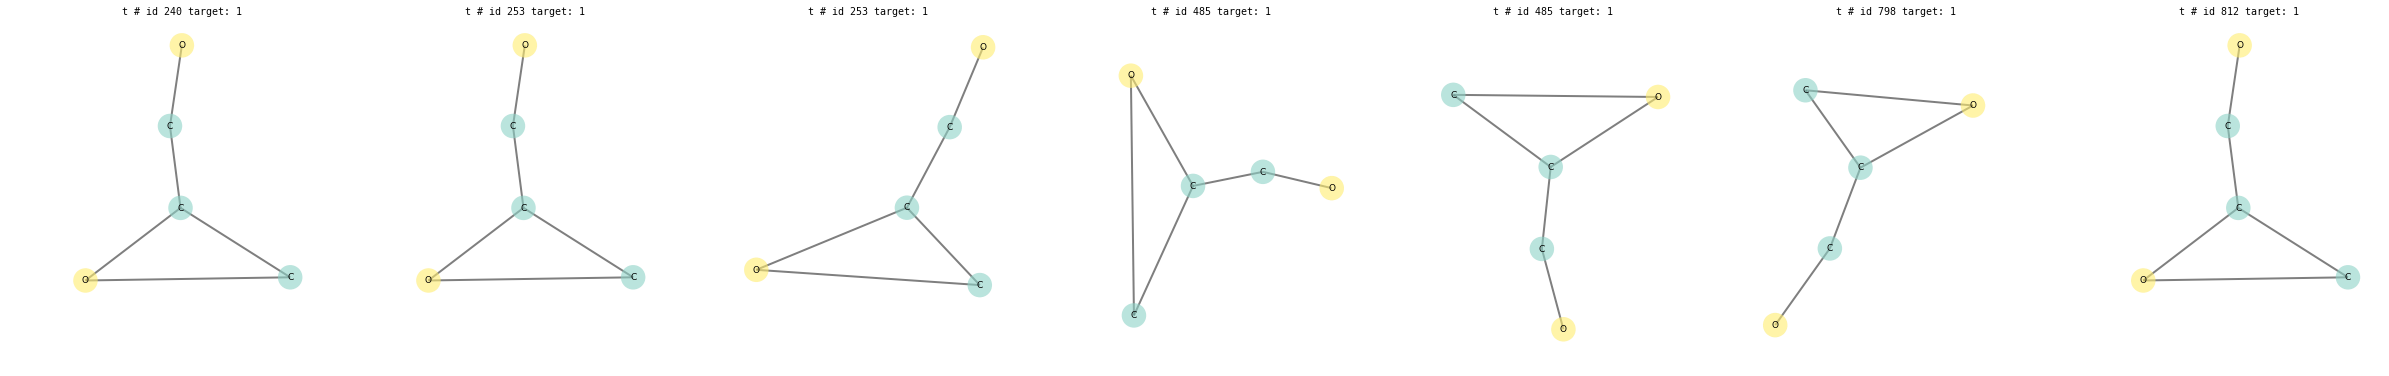

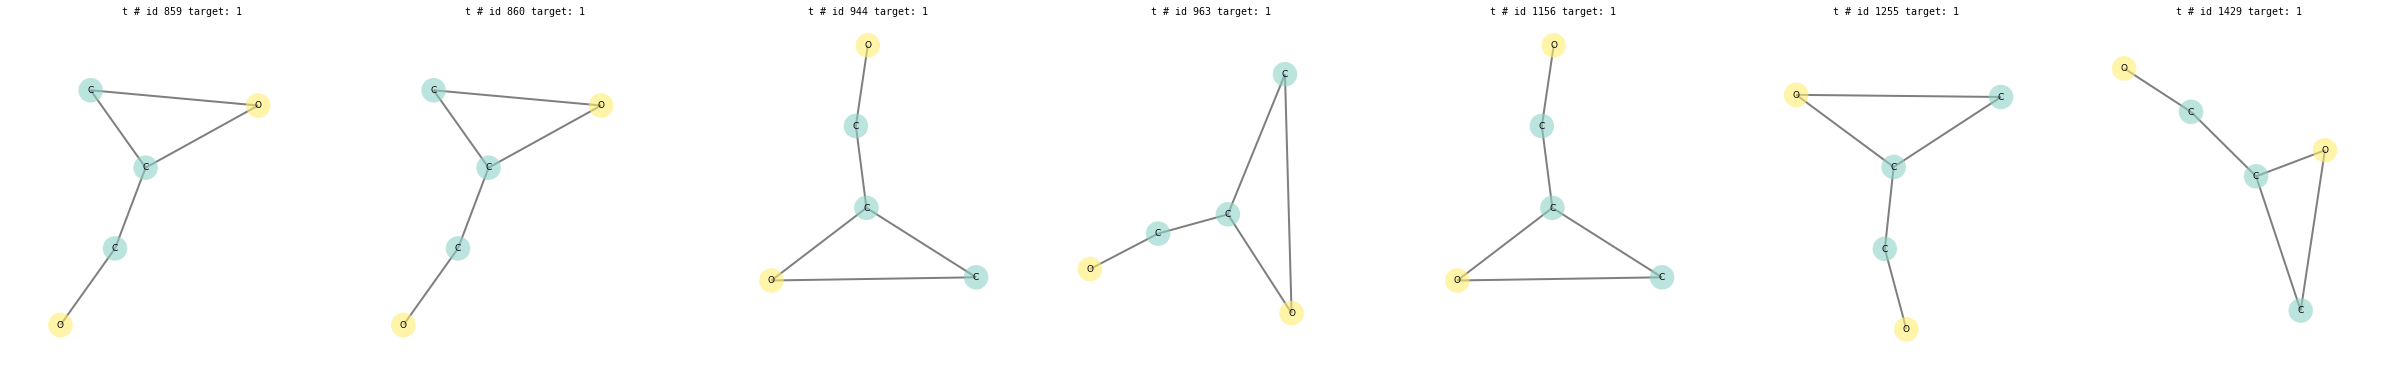

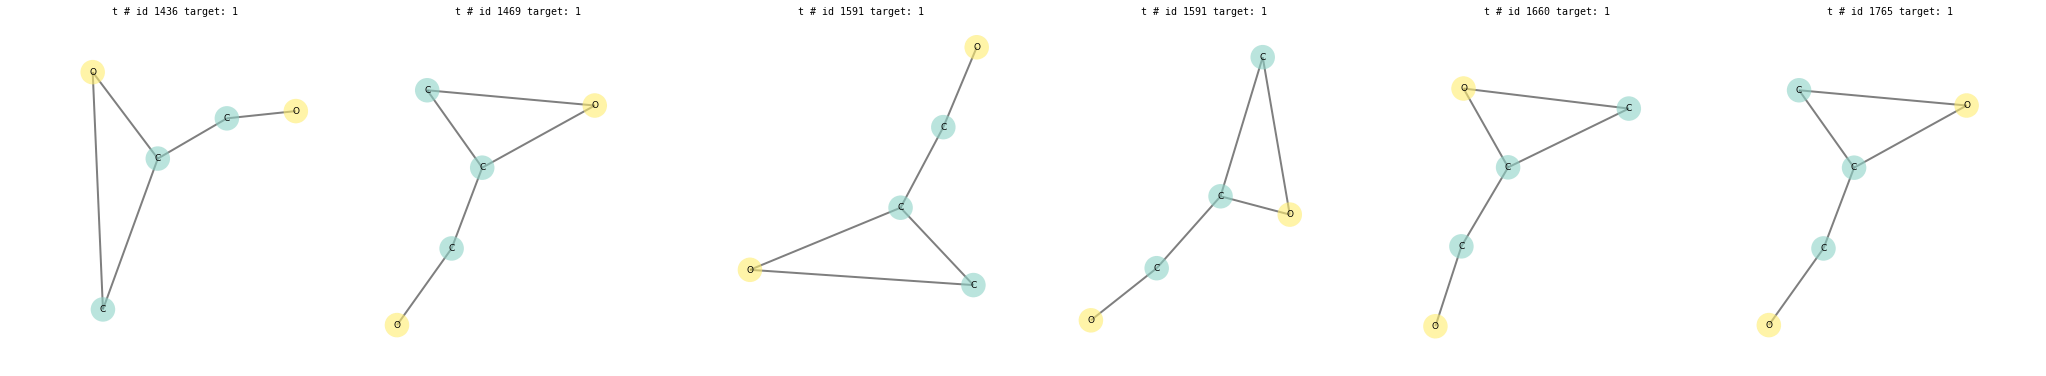

cluster id: 8  num: 27


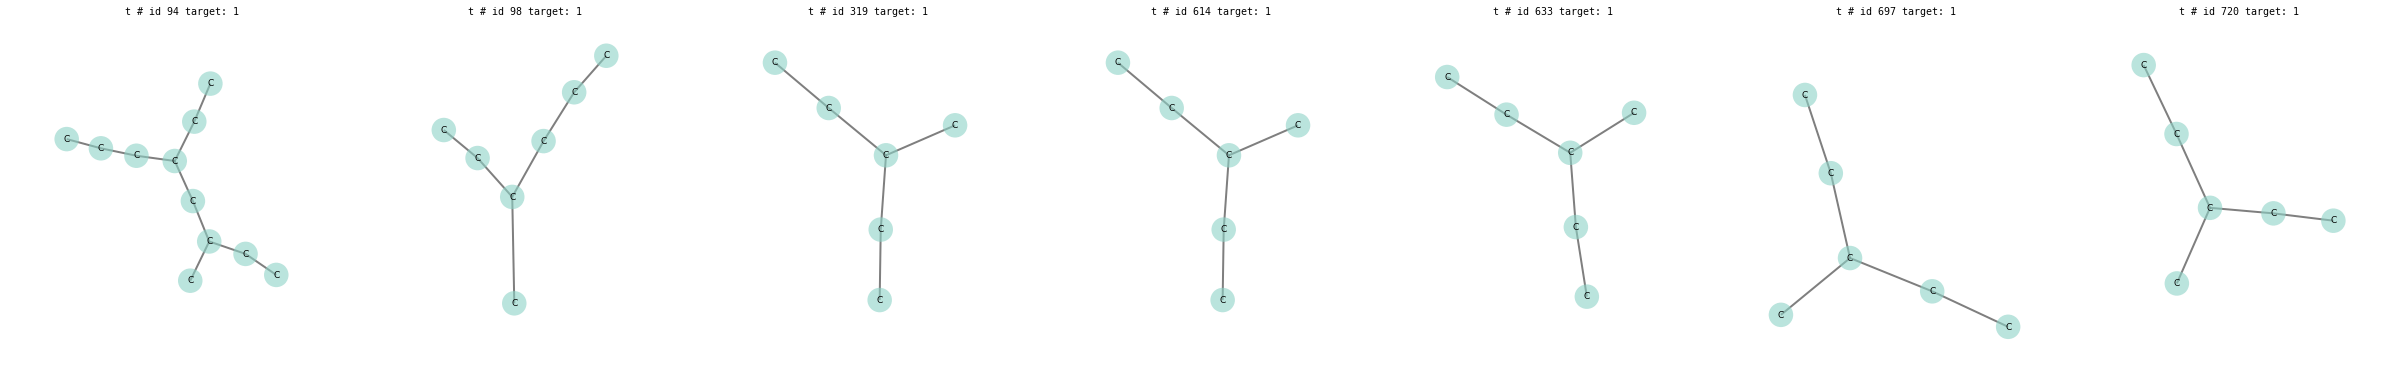

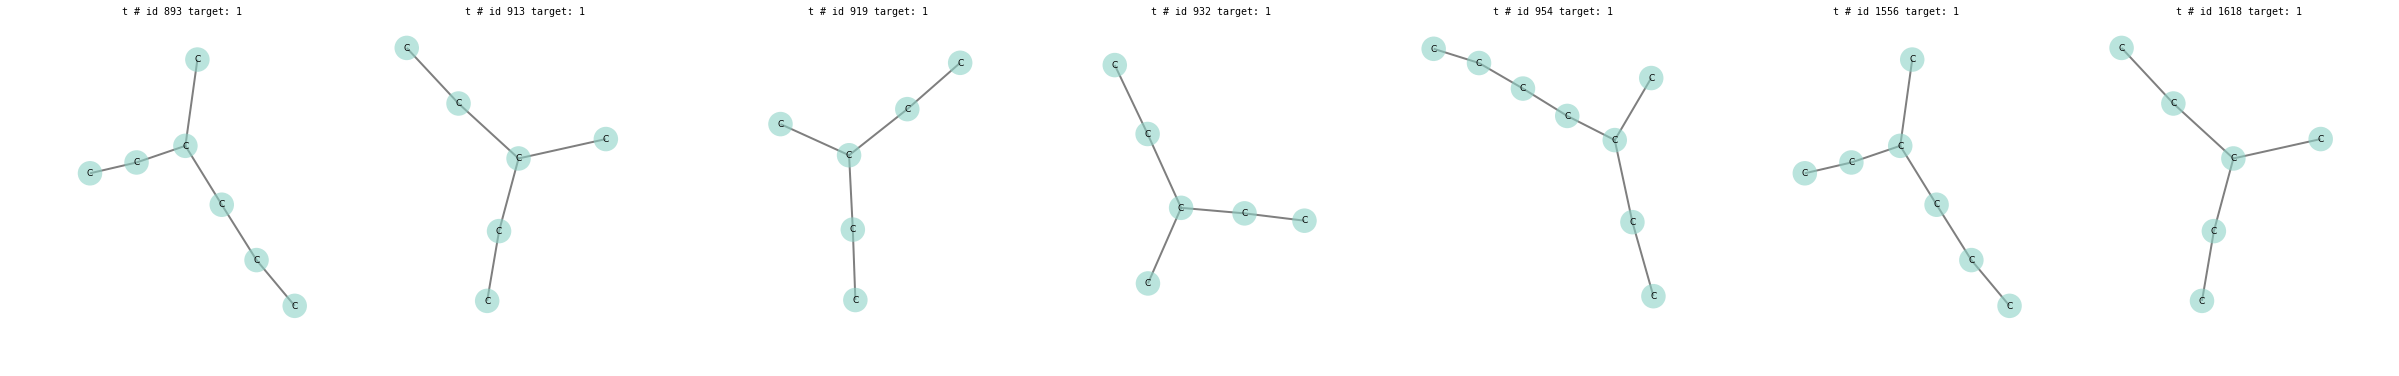

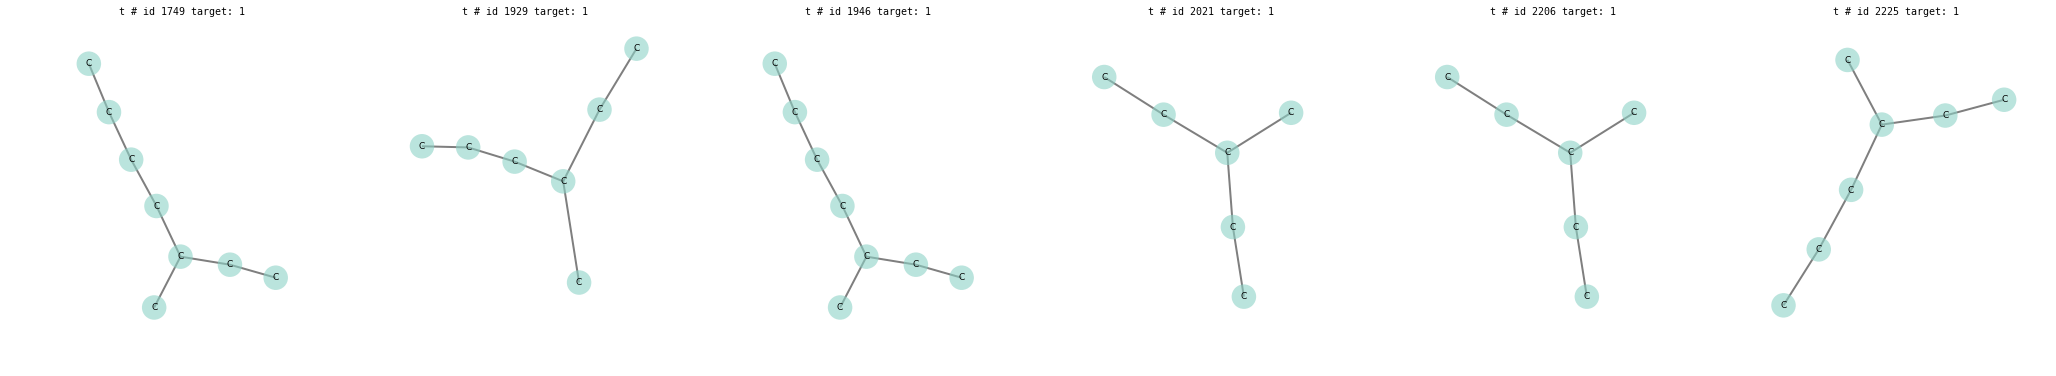

cluster id: 9  num: 21


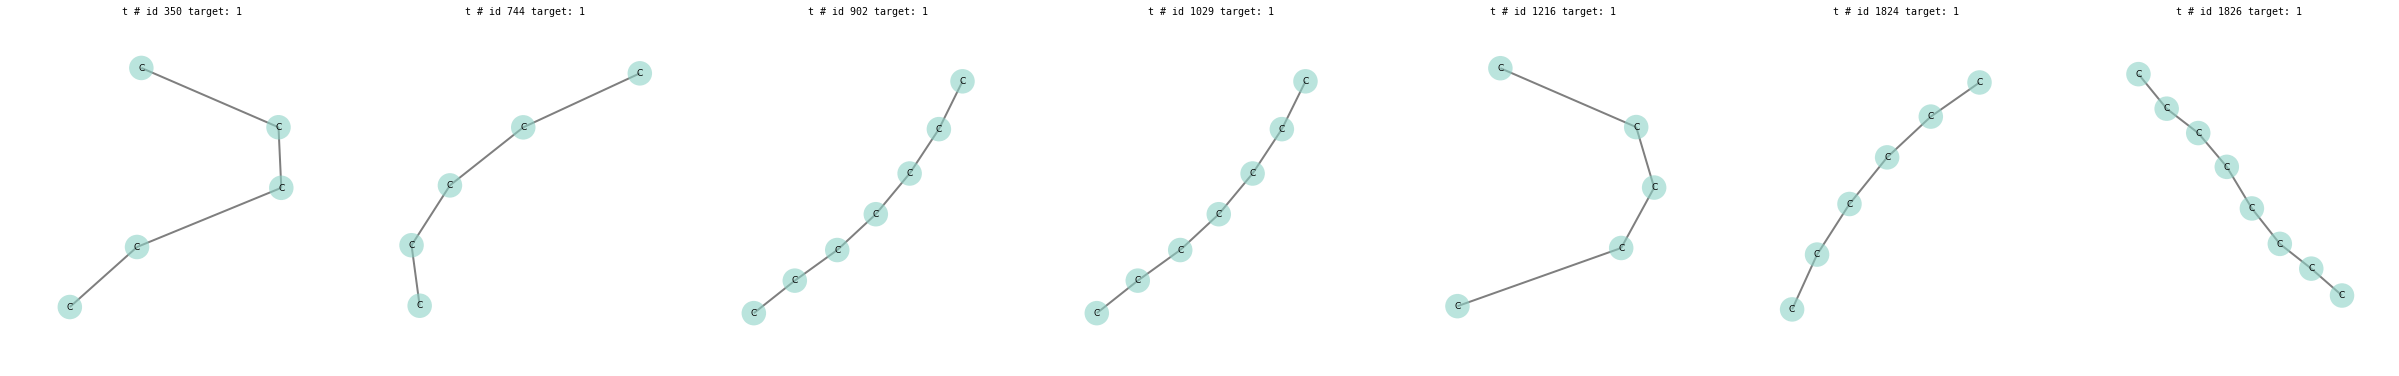

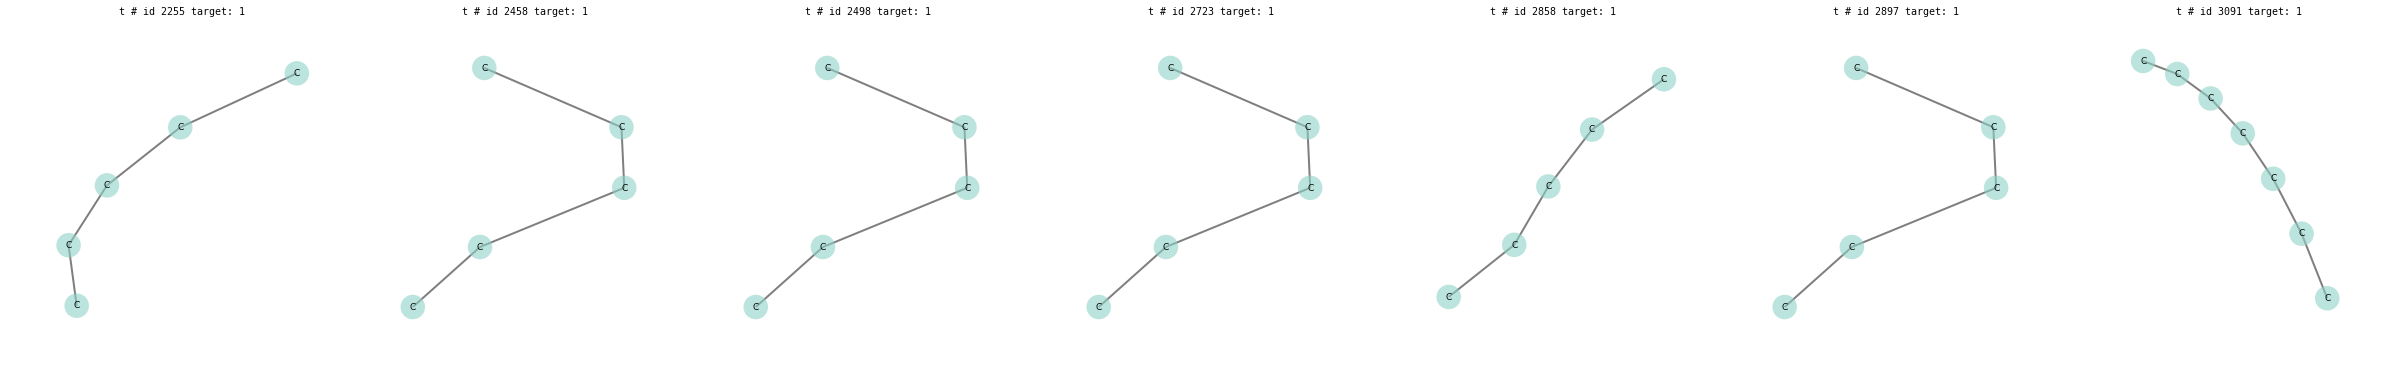

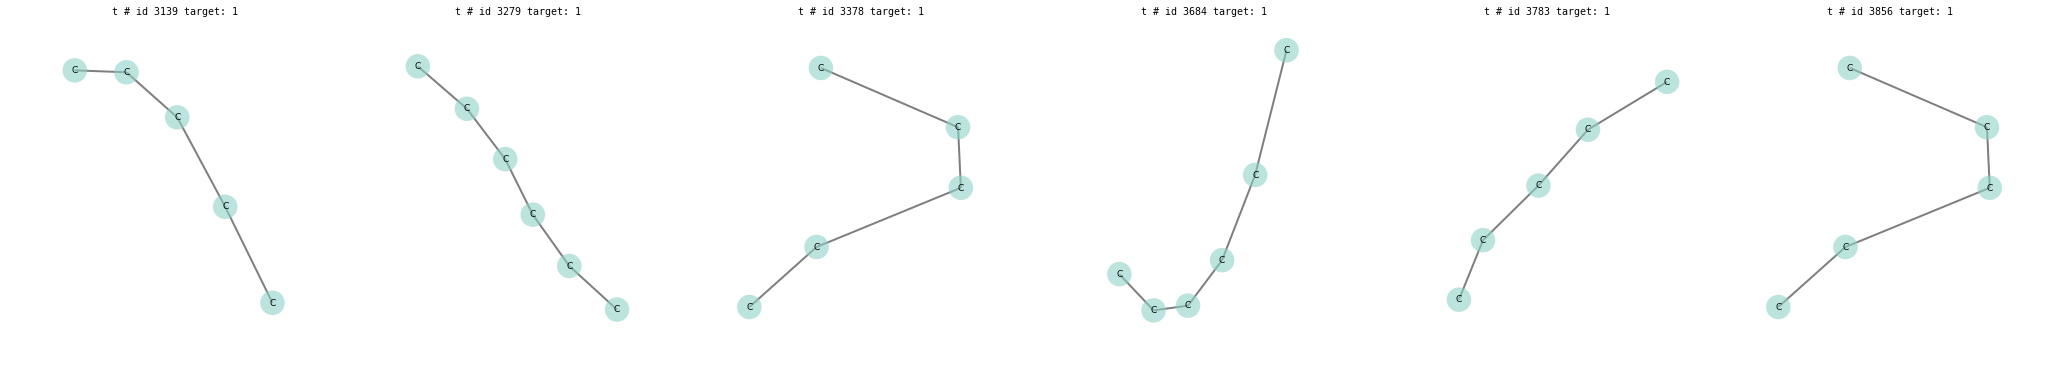

cluster id: 10  num: 21


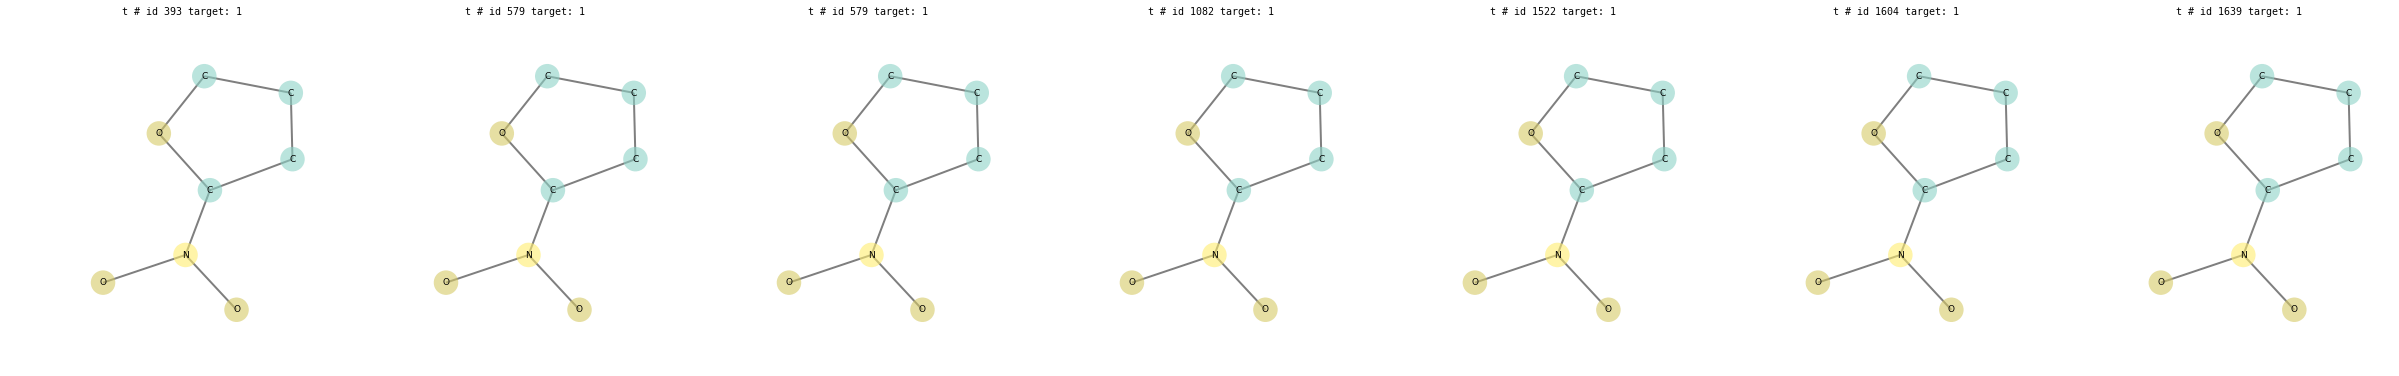

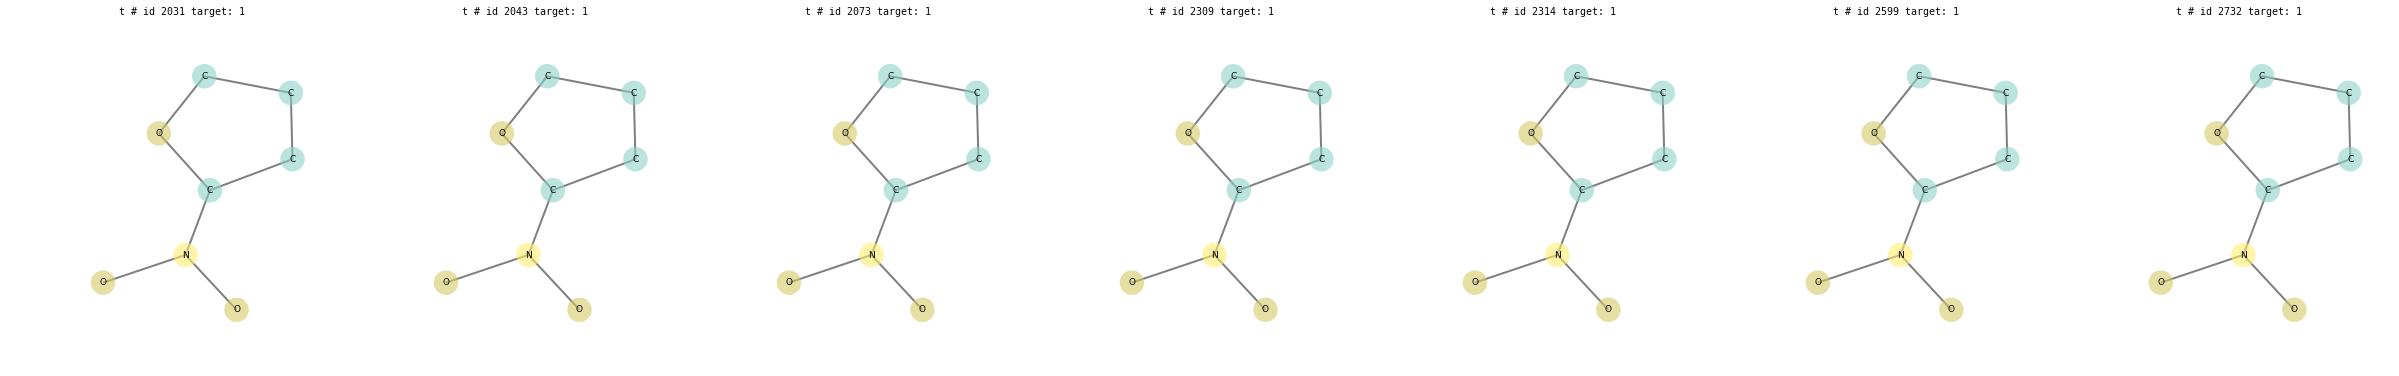

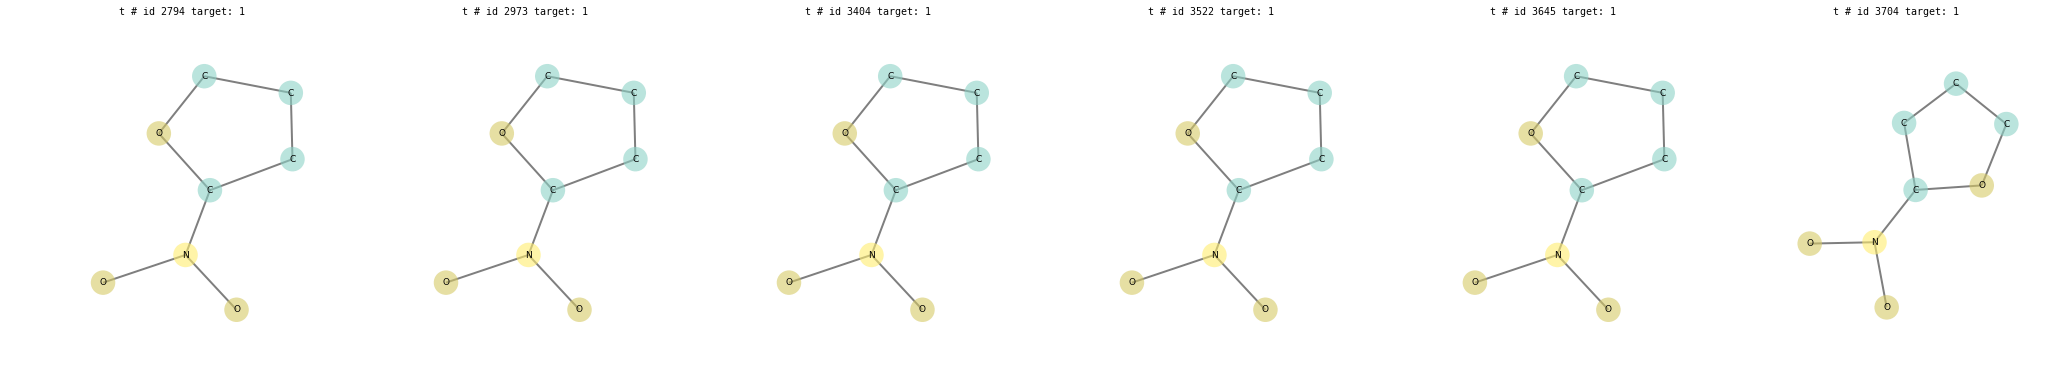

cluster id: 11  num: 11


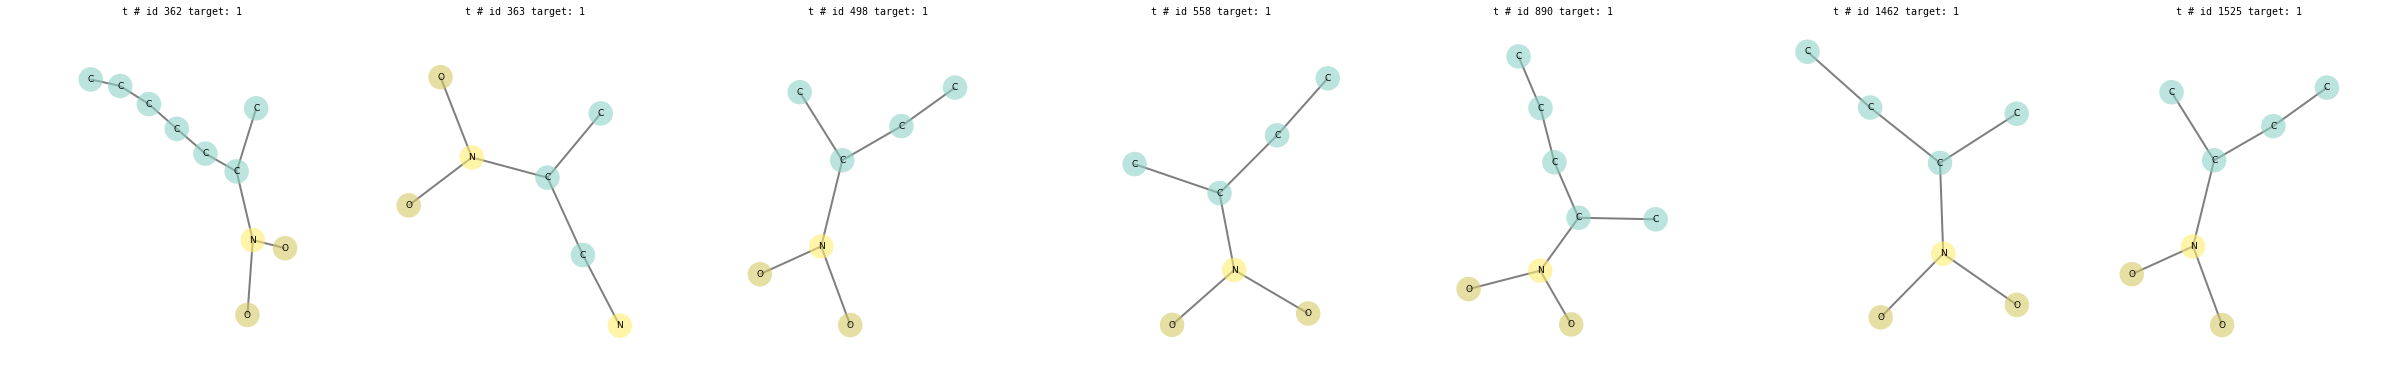

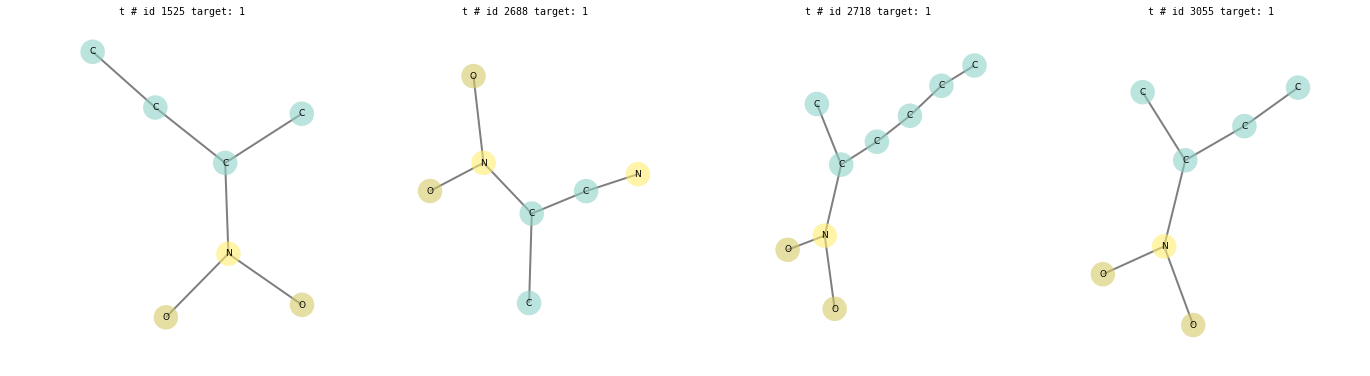

cluster id: -1  num: 294


In [12]:
from collections import defaultdict
clustered_graphs = defaultdict(list)
from itertools import izip
for cluster_id, graph in izip(cluster_ids, graphs):
    clustered_graphs[cluster_id].append(graph)

for cluster_id in clustered_graphs:
    logger.info('cluster id: %d  num: %d' % (cluster_id, len(clustered_graphs[cluster_id])))
    #data_matrix = vectorizer.transform(clustered_graphs[cluster_id])
    #distance_matrix = pairwise_distances(data_matrix)
    #print distance_matrix
    if cluster_id != -1:
        draw_graph_set(clustered_graphs[cluster_id][:20], n_graphs_per_line=7, size=6, vertex_color='_label_', prog='neato', colormap='Set3')

---

In [13]:
%%time
#multiclass logistic regression 
X = data_matrix
y = cluster_ids
#predict class
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', 
                        dual=False, 
                        tol=0.0001, 
                        C=1.0, 
                        fit_intercept=True, 
                        intercept_scaling=1, 
                        class_weight='balanced', 
                        random_state=None, 
                        solver='liblinear', 
                        max_iter=100, 
                        multi_class='ovr', 
                        verbose=0, 
                        warm_start=False, 
                        n_jobs=-1)

#predictions computation
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y, n_folds=5)
results=[]
for train_index, test_index in skf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    probs = lr.predict_proba(X_test)
    targets = lr.predict(X_test)
    results += [(i,prob, target) for i, prob, target in zip(test_index, probs, targets)]
preds = np.array([prob for i,prob,target in sorted(results)])
targs = np.array([target for i,prob,target in sorted(results)])

CPU times: user 1min 21s, sys: 2.25 s, total: 1min 23s
Wall time: 21.2 s


In [14]:
for t,p,v in zip(targs,preds,y):
    print v,t,p

-1 -1 [ 0.6698631   0.01611979  0.04985733  0.05908453  0.02106156  0.03238271
  0.02093368  0.01679221  0.02090312  0.02912945  0.02132795  0.01608286
  0.02646173]
-1 -1 [ 0.38479714  0.02505495  0.26028631  0.02655112  0.02864092  0.05076067
  0.04043048  0.02846247  0.02358859  0.04075574  0.02665456  0.02502333
  0.03899371]
0 0 [ 0.05550965  0.70148918  0.06870898  0.01245221  0.01110964  0.01189517
  0.0102663   0.02551737  0.0124999   0.00974     0.01423353  0.03092663
  0.03565144]
-1 -1 [ 0.66658398  0.02124103  0.04401625  0.02369396  0.02431163  0.02455706
  0.03102534  0.03166867  0.02210951  0.02484264  0.02423608  0.02225174
  0.0394621 ]
-1 -1 [ 0.63652734  0.01882082  0.07267594  0.06749061  0.0243625   0.03330168
  0.02459799  0.01869684  0.02325575  0.02068872  0.0201396   0.01876793
  0.02067429]
1 1 [ 0.04993902  0.011766    0.7932013   0.01398015  0.01554943  0.0275572
  0.01134312  0.00917693  0.01183962  0.01836578  0.01500796  0.01113396
  0.01113953]
2 2 [ 0.0

In [ ]:
# start from test graphs
# use global estimator
# annotate importance
# threshold it and make attribute
# make minor contraction
# extract constracted subgraph
# score it with multiclass estimator
# take max prediction as new label
# display abstract graph

---